In [7]:
#we load the necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs

quarters = ['2023_Q1', '2023_Q3', '2023_Q4',
            '2024_Q2', '2024_Q4',
            '2025_Q1', '2025_Q2']
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller


In [8]:
from functions.position_VB import positionVB

In [22]:
def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)

fastEMA_parameters = [15, 20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240, 300, 360, 420]

# create an empty DataFrame to store summary for all quarters
summary_2MAs = pd.DataFrame()

for quarter in quarters:

    print(f'Processing quarter: {quarter}')

    data2 = pd.read_parquet(f'data/data2_{quarter}.parquet')

    # Lets set the datetime index
    data2.set_index('datetime', inplace = True)

    pos_flat = np.zeros(len(data2))
    breaks = (data2.index.time >= pd.to_datetime("16:41").time()) & \
          (data2.index.time <= pd.to_datetime("18:10").time())

    pos_flat[breaks] = 1

    dweek_ = data2.index.dayofweek + 1
    time_ = data2.index.time
    pos_flat[((dweek_ == 5) & (time_ > pd.to_datetime('17:00').time())) |      # end of Friday
          (dweek_ == 6) |                                                      # whole Saturday (just in case)
          ((dweek_ == 7) & (time_ <= pd.to_datetime('18:00').time()))] = 1

    # apply the strategy
    ##############################################################
    XAG = data2['XAG']

    for fastEMA in fastEMA_parameters:
        for slowEMA in slowEMA_parameters:

                    # ensure that fastEMA is less than slowEMA
                    if fastEMA >= slowEMA:
                        continue

                    print(f"  fastEMA = {fastEMA}, slowEMA = {slowEMA}")

                    # We calculate the appropriate EMA
                    fastEMA_values = XAG.ewm(span = fastEMA).mean()
                    slowEMA_values = XAG.ewm(span= slowEMA).mean()

                    # Insert NaNs wherever the original price is missing
                    fastEMA_values[data2['XAG'].isna()] = np.nan
                    slowEMA_values[data2['XAG'].isna()] = np.nan

                    # Calculate position for momentum strategy
                    cond2b_mom_long = fastEMA_values.shift(1) > slowEMA_values.shift(1)

                    # let's add filters that check for the presence of NaN values
                    fastEMA_nonmiss = fastEMA_values.shift(1).notna()
                    slowEMA_nonmiss = slowEMA_values.shift(1).notna()

                    # Now we can add these conditions to our strategies
                    # if any of the values is missing,
                    # we cannot make a position decision

                    pos_mom = np.where(fastEMA_nonmiss & slowEMA_nonmiss,
                                       np.where(cond2b_mom_long, 1, -1),
                                       np.nan)
                    pos_mr = -pos_mom

                    # Set position to 0 where pos_flat is 1
                    pos_mom[pos_flat == 1] = 0
                    pos_mr[pos_flat == 1] = 0

                    # Calculate gross pnl
                    pnl_gross_mom = np.where(np.isnan(pos_mom * data2["XAG"].diff()), 0, pos_mom * data2["XAG"].diff() * 5000)
                    pnl_gross_mr = np.where(np.isnan(pos_mr * data2["XAG"].diff()), 0, pos_mr * data2["XAG"].diff() * 5000)
                    # point value for XAG

                    # Calculate number of transactions
                    ntrans = np.abs(np.diff(pos_mom, prepend = 0))

                    # Calculate net pnl
                    pnl_net_mom = pnl_gross_mom - ntrans * 10 # cost $12 per transaction
                    pnl_net_mr = pnl_gross_mr - ntrans * 10   # cost $12 per transaction

                    # Aggregate to daily data
                    pnl_gross_mom = pd.Series(pnl_gross_mom)
                    pnl_gross_mom.index = data2['XAG'].index.time
                    pnl_gross_mom_d = pnl_gross_mom.groupby(data2['XAG'].index.date).sum()
                    pnl_gross_mr = pd.Series(pnl_gross_mr)
                    pnl_gross_mr.index = data2['XAG'].index.time
                    pnl_gross_mr_d = pnl_gross_mr.groupby(data2['XAG'].index.date).sum()

                    pnl_net_mom = pd.Series(pnl_net_mom)
                    pnl_net_mom.index = data2['XAG'].index.time
                    pnl_net_mom_d = pnl_net_mom.groupby(data2['XAG'].index.date).sum()
                    pnl_net_mr = pd.Series(pnl_net_mr)
                    pnl_net_mr.index = data2['XAG'].index.time
                    pnl_net_mr_d = pnl_net_mr.groupby(data2['XAG'].index.date).sum()

                    ntrans = pd.Series(ntrans)
                    ntrans.index = data2['XAG'].index.time
                    ntrans_d = ntrans.groupby(data2['XAG'].index.date).sum()

                    # Calculate Sharpe Ratio and PnL
                    gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                    net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                    gross_PnL_mom = pnl_gross_mom_d.sum()
                    net_PnL_mom = pnl_net_mom_d.sum()
                    gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                    net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                    gross_PnL_mr = pnl_gross_mr_d.sum()
                    net_PnL_mr = pnl_net_mr_d.sum()

                    av_daily_ntrans = ntrans_d.mean()
                    stat_mom = (net_SR_mom - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mom/1000)))
                    stat_mr = (net_SR_mr - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mr/1000)))

                    # Collect necessary results into one object
                    summary = pd.DataFrame({
                        'fastEMA': fastEMA,
                        'slowEMA': slowEMA,
                        'quarter': quarter,
                        'gross_SR_mom': gross_SR_mom,
                        'net_SR_mom': net_SR_mom,
                        'gross_PnL_mom': gross_PnL_mom,
                        'net_PnL_mom': net_PnL_mom,
                        'gross_SR_mr': gross_SR_mr,
                        'net_SR_mr': net_SR_mr,
                        'gross_PnL_mr': gross_PnL_mr,
                        'net_PnL_mr': net_PnL_mr,
                        'av_daily_ntrans': av_daily_ntrans,
                        'stat_mom': stat_mom,
                        'stat_mr': stat_mr
                    }, index=[0])

                    # Append results to the summary
                    summary_2MAs = pd.concat([summary_2MAs, summary], ignore_index=True)


Processing quarter: 2023_Q1
  fastEMA = 15, slowEMA = 90
  fastEMA = 15, slowEMA = 120
  fastEMA = 15, slowEMA = 150
  fastEMA = 15, slowEMA = 180
  fastEMA = 15, slowEMA = 240
  fastEMA = 15, slowEMA = 300
  fastEMA = 15, slowEMA = 360
  fastEMA = 15, slowEMA = 420
  fastEMA = 20, slowEMA = 90
  fastEMA = 20, slowEMA = 120
  fastEMA = 20, slowEMA = 150
  fastEMA = 20, slowEMA = 180
  fastEMA = 20, slowEMA = 240
  fastEMA = 20, slowEMA = 300
  fastEMA = 20, slowEMA = 360
  fastEMA = 20, slowEMA = 420
  fastEMA = 30, slowEMA = 90
  fastEMA = 30, slowEMA = 120
  fastEMA = 30, slowEMA = 150
  fastEMA = 30, slowEMA = 180
  fastEMA = 30, slowEMA = 240
  fastEMA = 30, slowEMA = 300
  fastEMA = 30, slowEMA = 360
  fastEMA = 30, slowEMA = 420
  fastEMA = 45, slowEMA = 90
  fastEMA = 45, slowEMA = 120
  fastEMA = 45, slowEMA = 150
  fastEMA = 45, slowEMA = 180
  fastEMA = 45, slowEMA = 240
  fastEMA = 45, slowEMA = 300
  fastEMA = 45, slowEMA = 360
  fastEMA = 45, slowEMA = 420
  fastEMA = 60, 

In [23]:
summary_2MAs

fastEMA  slowEMA  quarter  gross_SR_mom  net_SR_mom  gross_PnL_mom  \
0         15       90  2023_Q1     -1.799121   -2.546416       -16555.0   
1         15      120  2023_Q1     -1.003071   -1.719519        -9225.0   
2         15      150  2023_Q1     -0.473979   -1.150668        -4135.0   
3         15      180  2023_Q1     -0.408583   -1.051680        -3605.0   
4         15      240  2023_Q1     -0.004068   -0.597069          -35.0   
..       ...      ...      ...           ...         ...            ...   
380       90      180  2025_Q2     -0.564662   -0.786511        -8620.0   
381       90      240  2025_Q2     -1.463410   -1.660873       -23360.0   
382       90      300  2025_Q2     -0.559563   -0.749417        -8480.0   
383       90      360  2025_Q2     -0.425186   -0.605665        -6350.0   
384       90      420  2025_Q2     -0.054651   -0.229644         -810.0   

     net_PnL_mom  gross_SR_mr  net_SR_mr  gross_PnL_mr  net_PnL_mr  \
0       -23955.0     1.799121   1.017042       16555.0      9155.0   
1       -16105.0     1.003071   0.259632        9225.0      2345.0   
2       -10235.0     0.473979  -0.229629        4135.0     -1965.0   
3        -9465.0     0.408583  -0.260662        3605.0     -2255.0   
4        -5235.0     0.004068  -0.611520          35.0     -5165.0   
..           ...          ...        ...           ...         ...   
380     -12065.0     0.564662   0.335981        8620.0      5105.0   
381     -26665.0     1.463410   1.259012       23360.0     19985.0   
382     -11405.0     0.559563   0.363404        8480.0      5485.0   
383      -9075.0     0.425186   0.238782        6350.0      3555.0   
384      -3415.0     0.054651  -0.126236         810.0     -1865.0   

     av_daily_ntrans  stat_mom   stat_mr  
0           9.487179 -9.675958  1.144887  
1           8.820513 -6.168333 -0.204862  
2           7.820513 -3.839145 -0.492859  
3           7.512821 -3.487558 -0.618532  
4           6.666667 -1.816052 -1.825010  
..               ...       ...       ...  
380         4.461538 -3.203810 -0.267387  
381         4.282051 -7.094905  2.273227  
382         3.794872 -3.041145 -0.232488  
383         3.538462 -2.438569 -0.331317  
384         3.384615 -0.896133 -0.390308  

[385 rows x 14 columns]

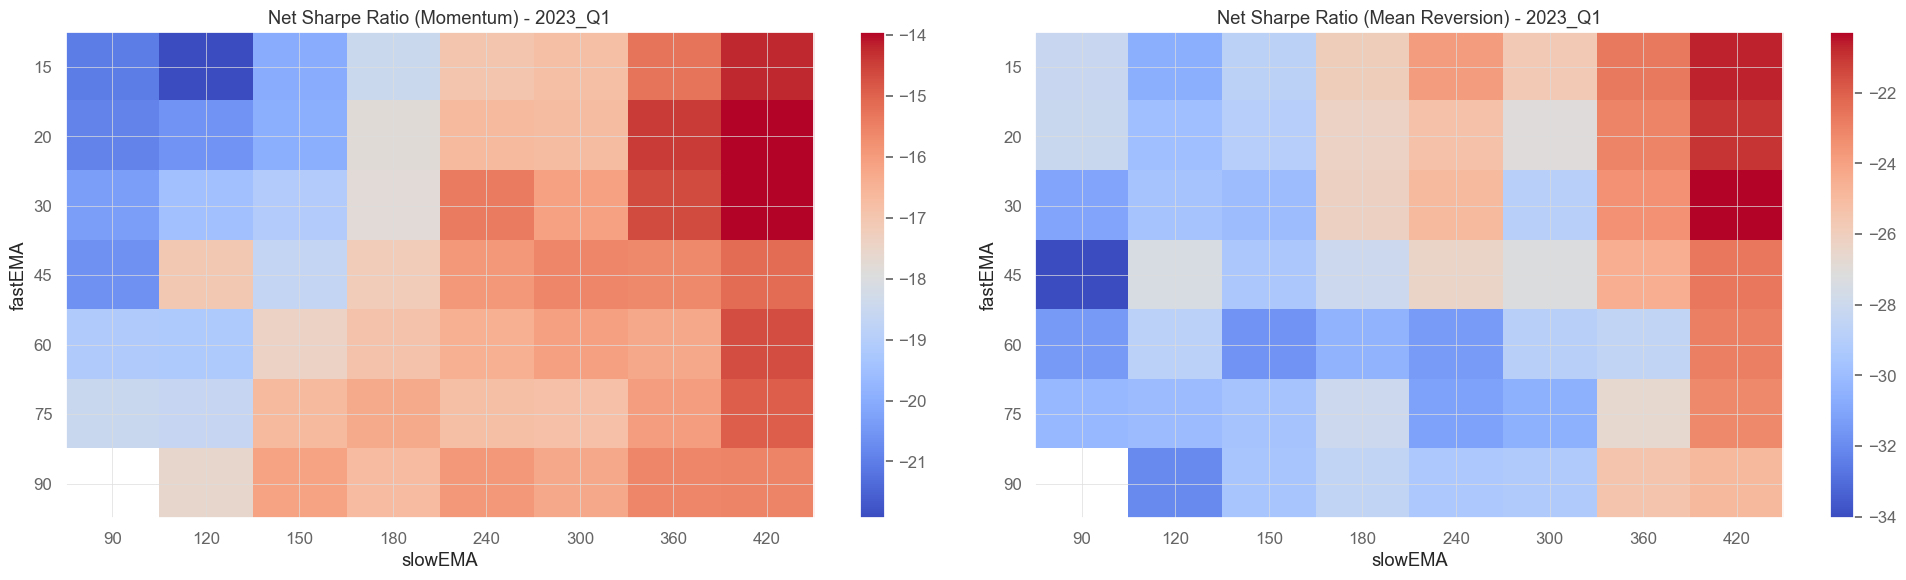

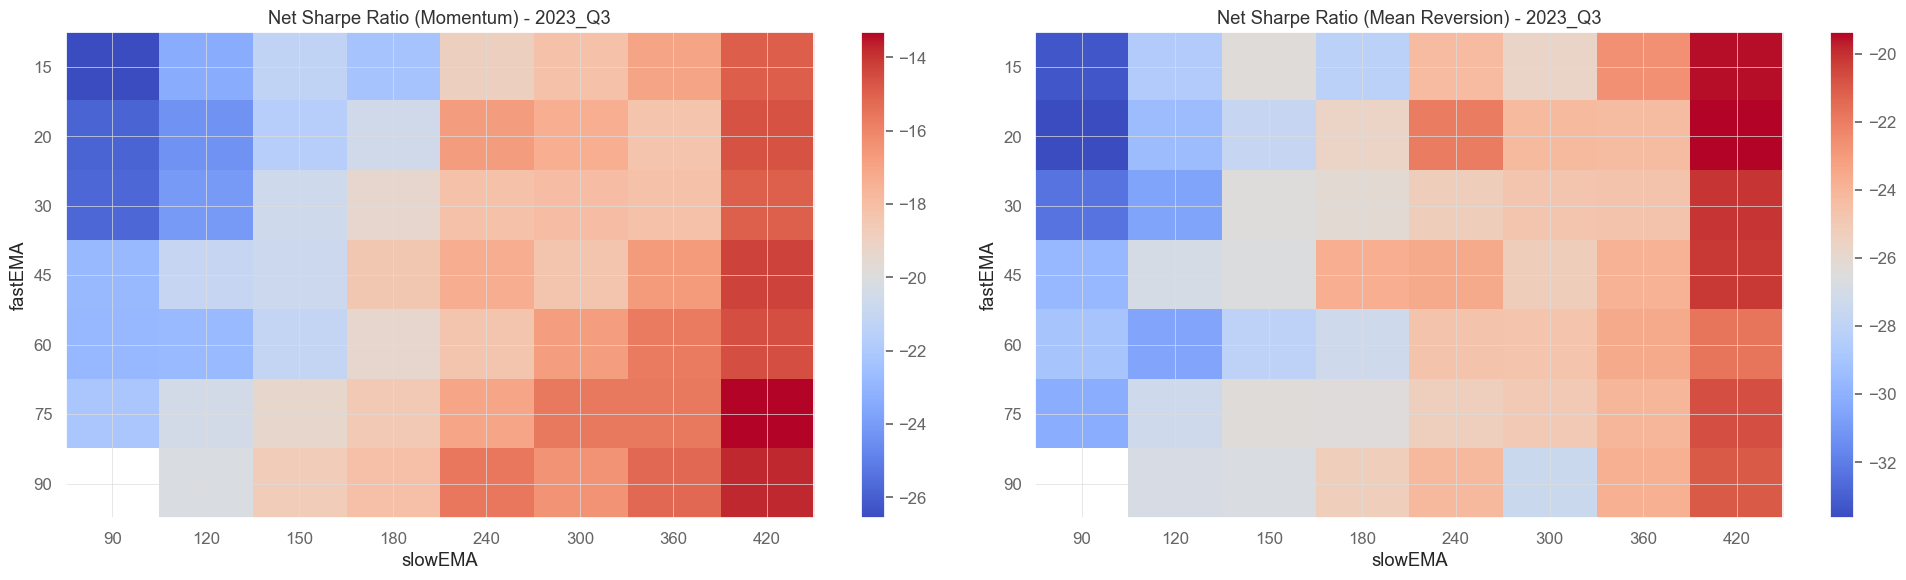

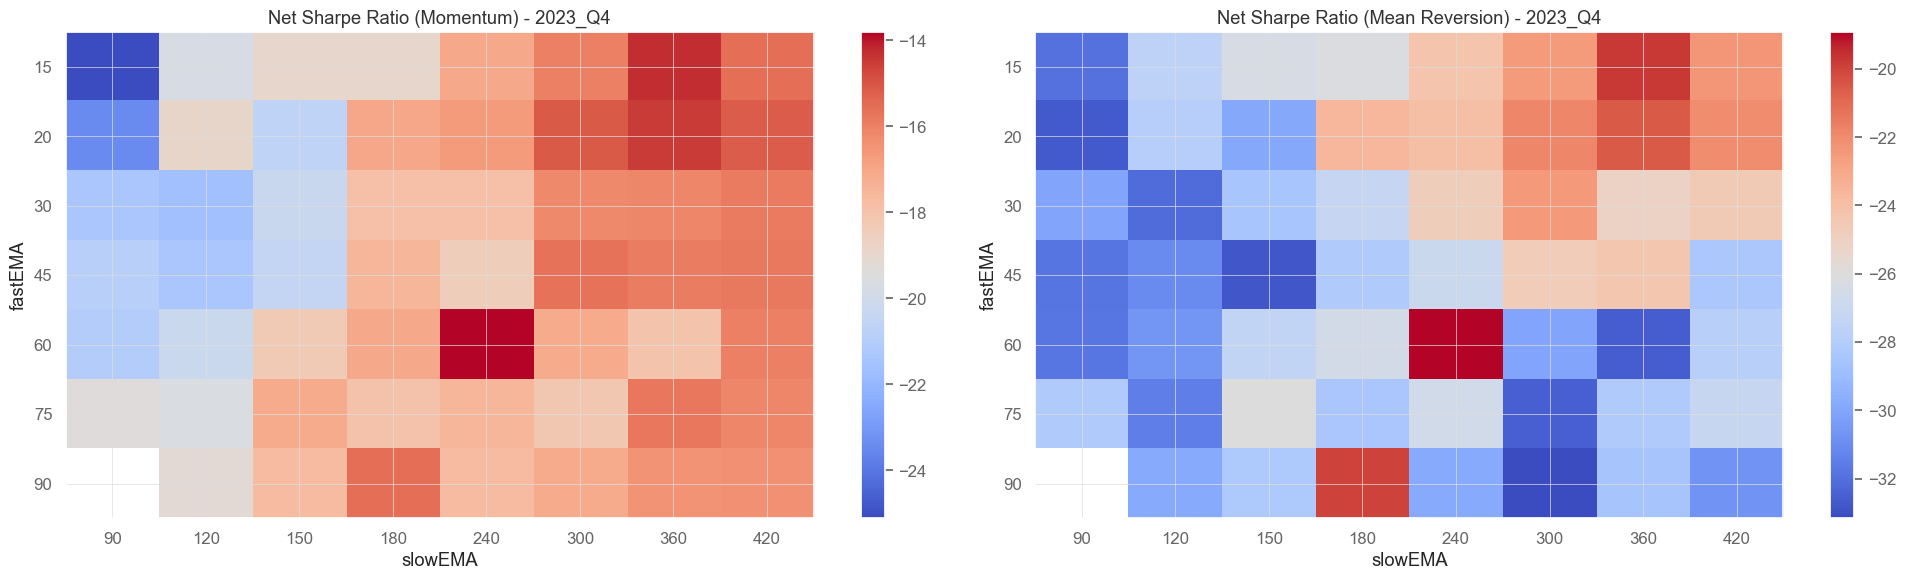

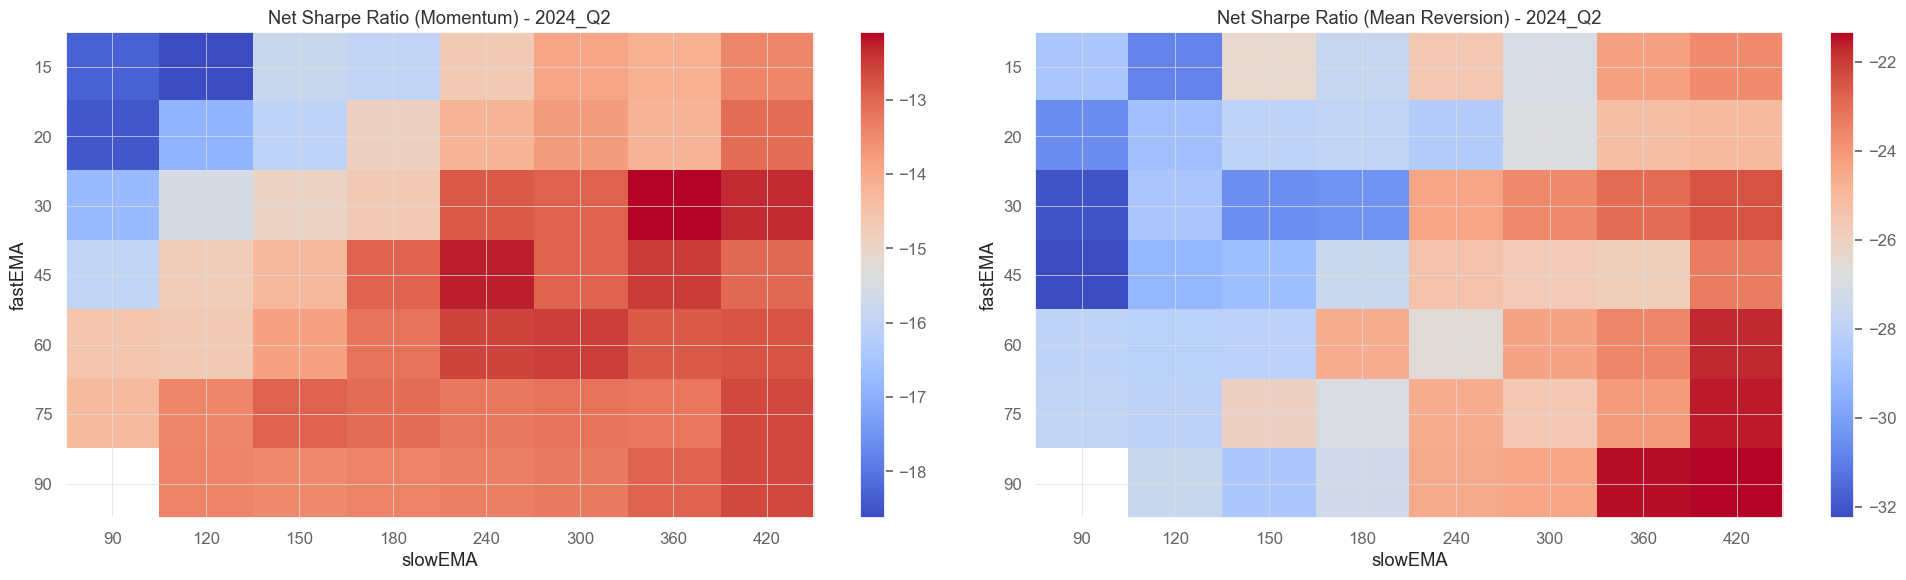

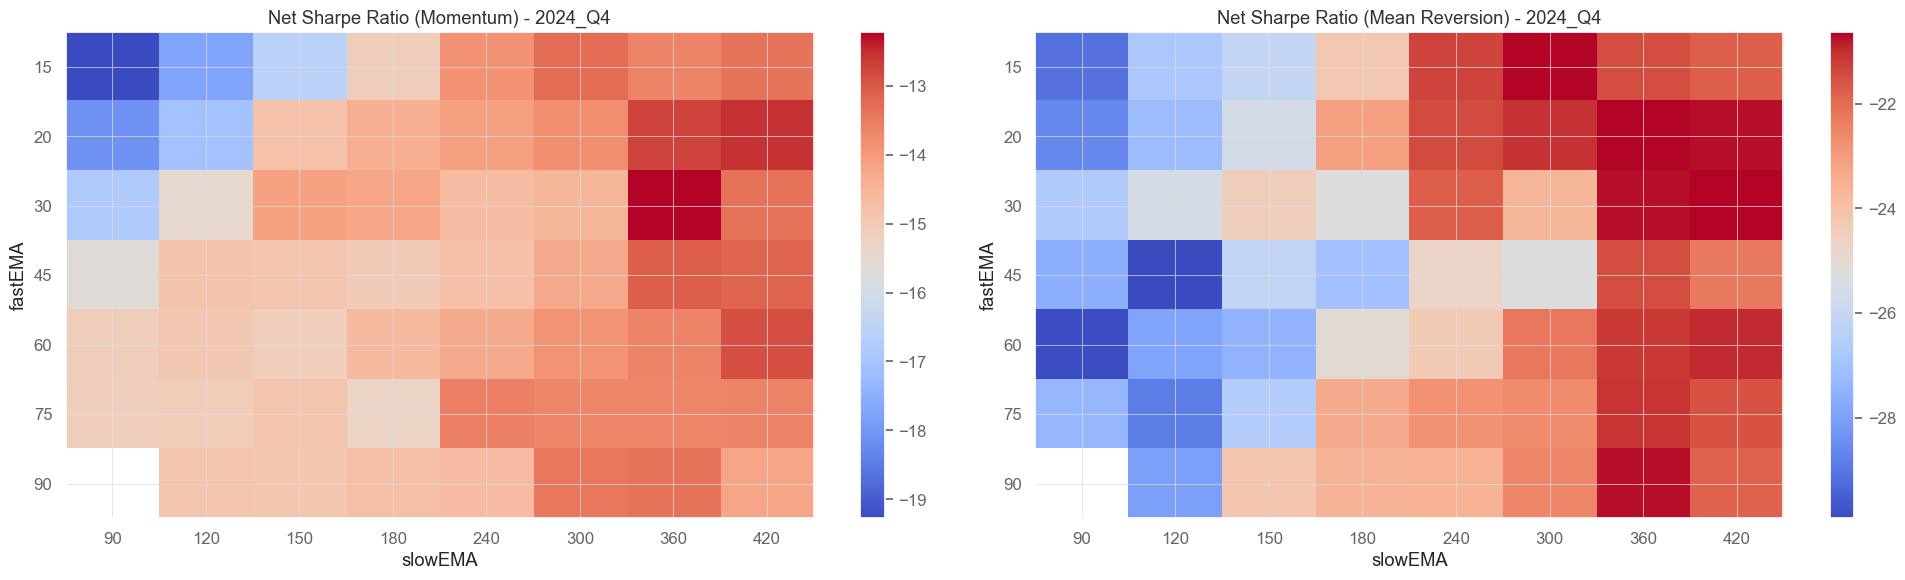

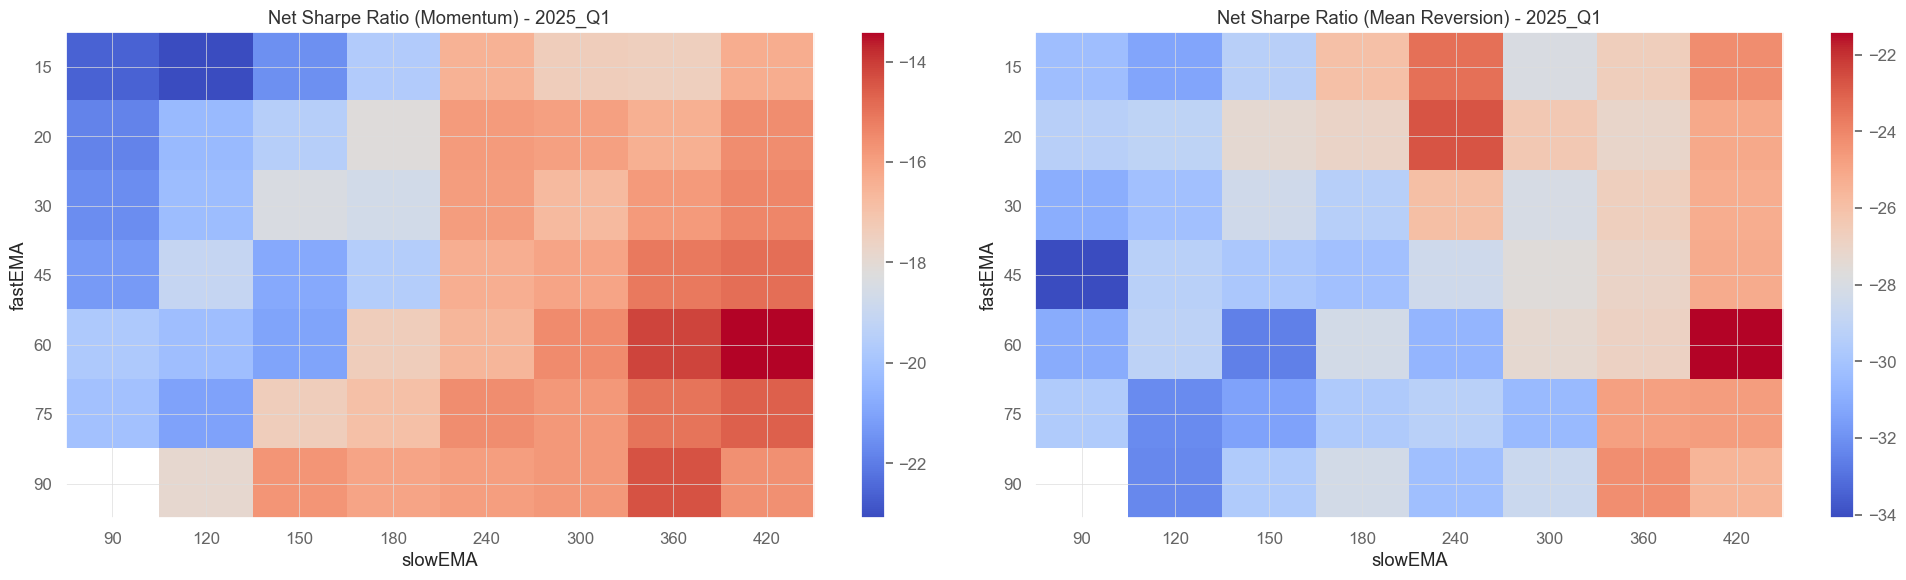

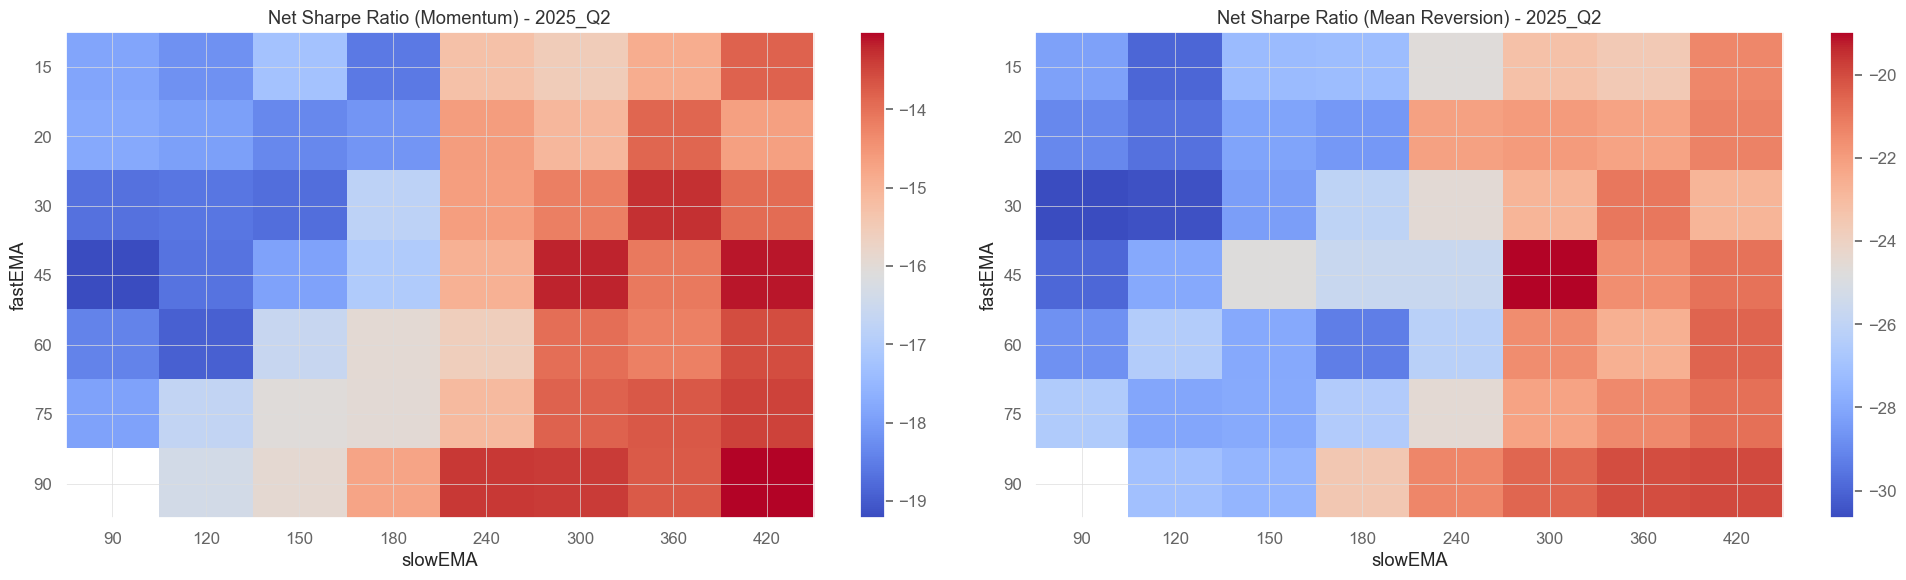

In [24]:

for quarter in quarters:
    quarter_data = summary_2MAs_nonans[summary_2MAs_nonans['quarter'] == quarter]

    # Create figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot momentum strategy heatmap
    quarter_data_pivot_mom = quarter_data.pivot(index='fastEMA', columns='slowEMA', values='net_SR_mom')
    im1 = axes[0].imshow(quarter_data_pivot_mom.values, cmap='coolwarm', aspect='auto')
    axes[0].set_xticks(range(len(quarter_data_pivot_mom.columns)))
    axes[0].set_yticks(range(len(quarter_data_pivot_mom.index)))
    axes[0].set_xticklabels(quarter_data_pivot_mom.columns)
    axes[0].set_yticklabels(quarter_data_pivot_mom.index)
    axes[0].set_xlabel('slowEMA')
    axes[0].set_ylabel('fastEMA')
    axes[0].set_title(f'Net Sharpe Ratio (Momentum) - {quarter}')
    plt.colorbar(im1, ax=axes[0])

    # Plot mean reversion strategy heatmap
    quarter_data_pivot_mr = quarter_data.pivot(index='fastEMA', columns='slowEMA', values='net_SR_mr')
    im2 = axes[1].imshow(quarter_data_pivot_mr.values, cmap='coolwarm', aspect='auto')
    axes[1].set_xticks(range(len(quarter_data_pivot_mr.columns)))
    axes[1].set_yticks(range(len(quarter_data_pivot_mr.index)))
    axes[1].set_xticklabels(quarter_data_pivot_mr.columns)
    axes[1].set_yticklabels(quarter_data_pivot_mr.index)
    axes[1].set_xlabel('slowEMA')
    axes[1].set_ylabel('fastEMA')
    axes[1].set_title(f'Net Sharpe Ratio (Mean Reversion) - {quarter}')
    plt.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()


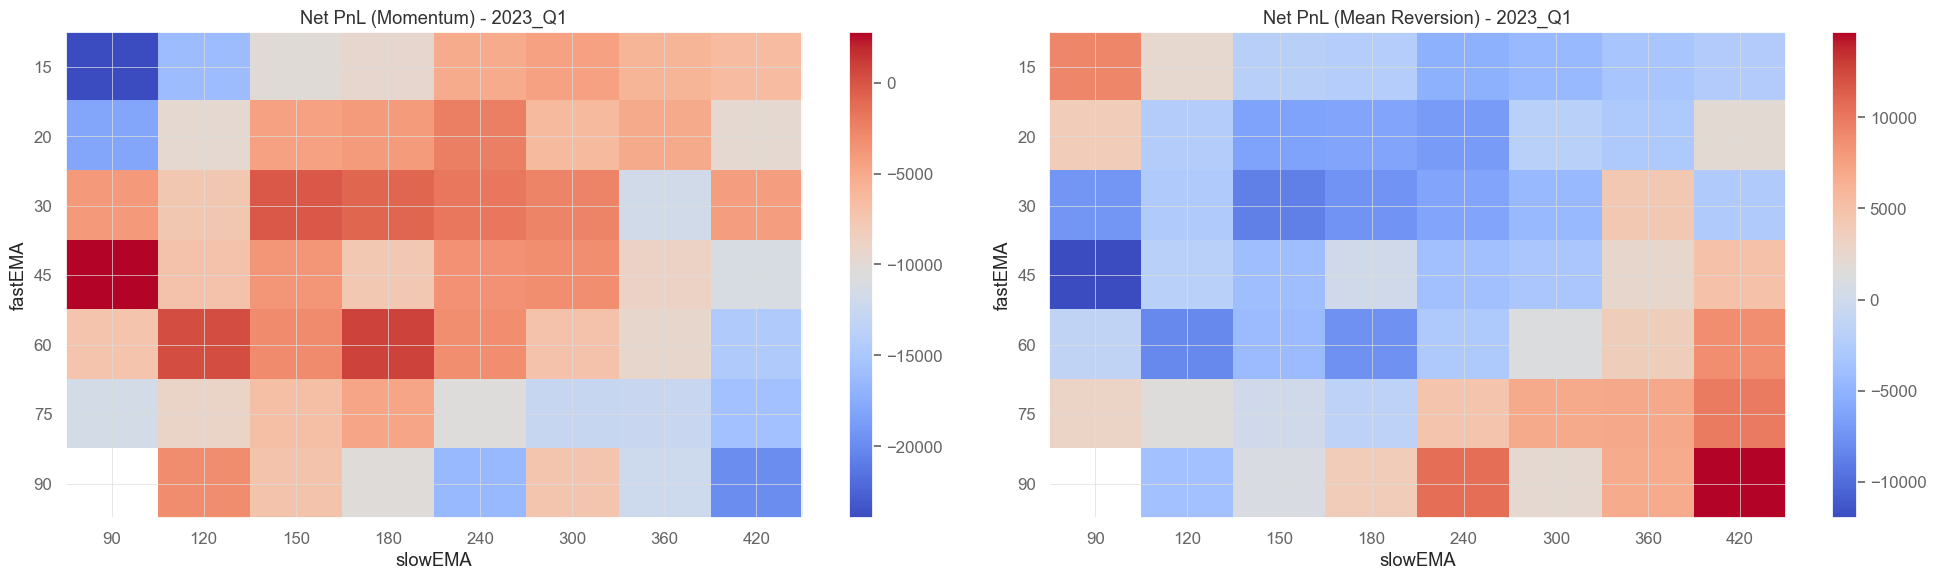

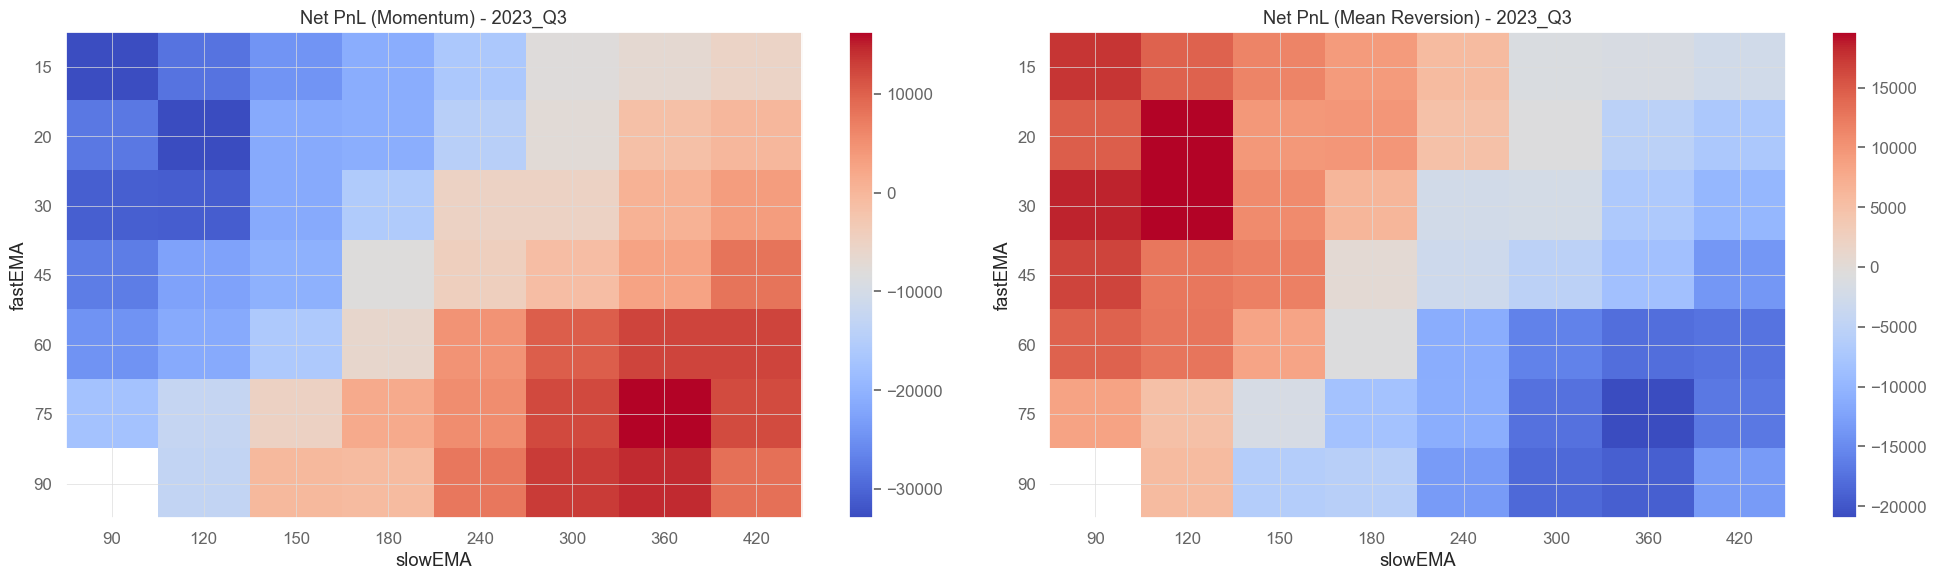

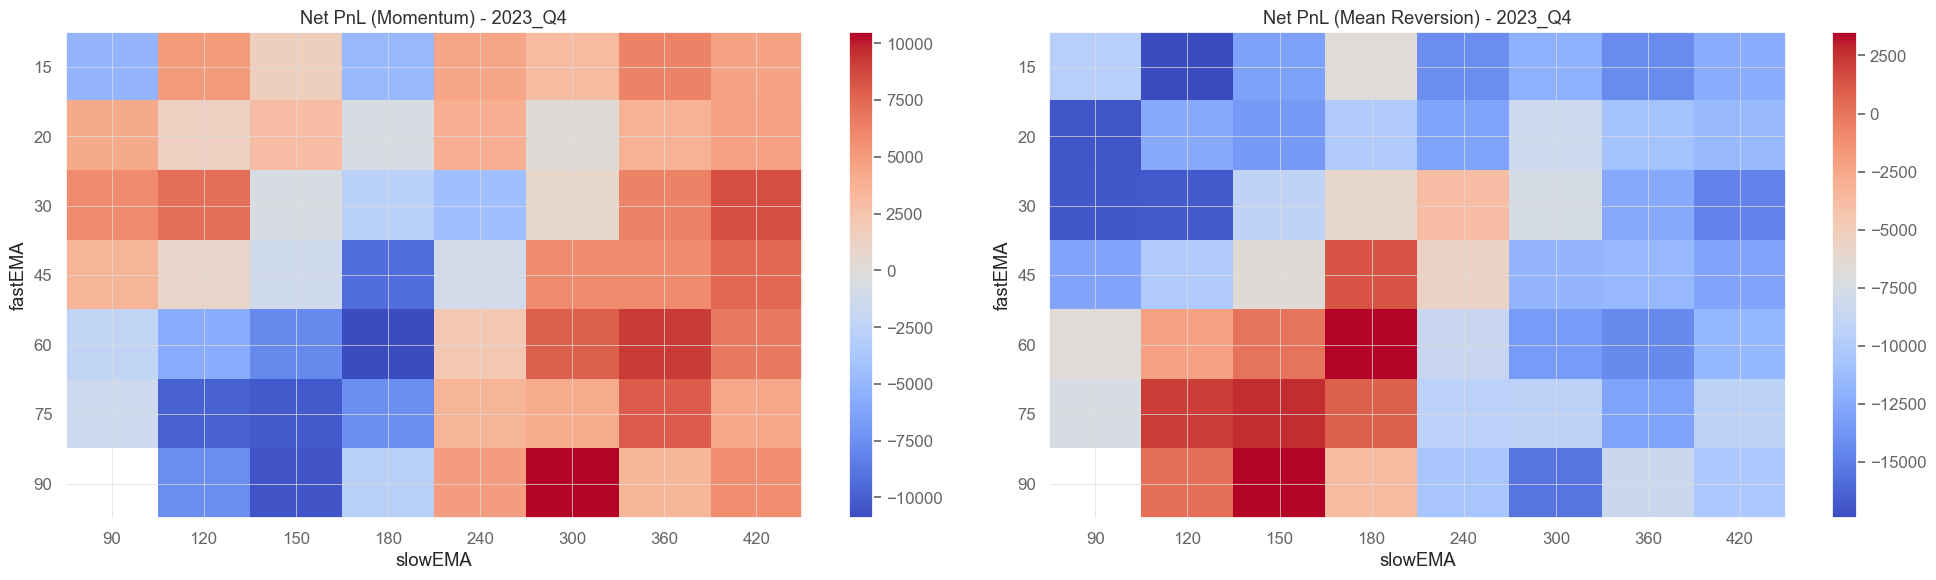

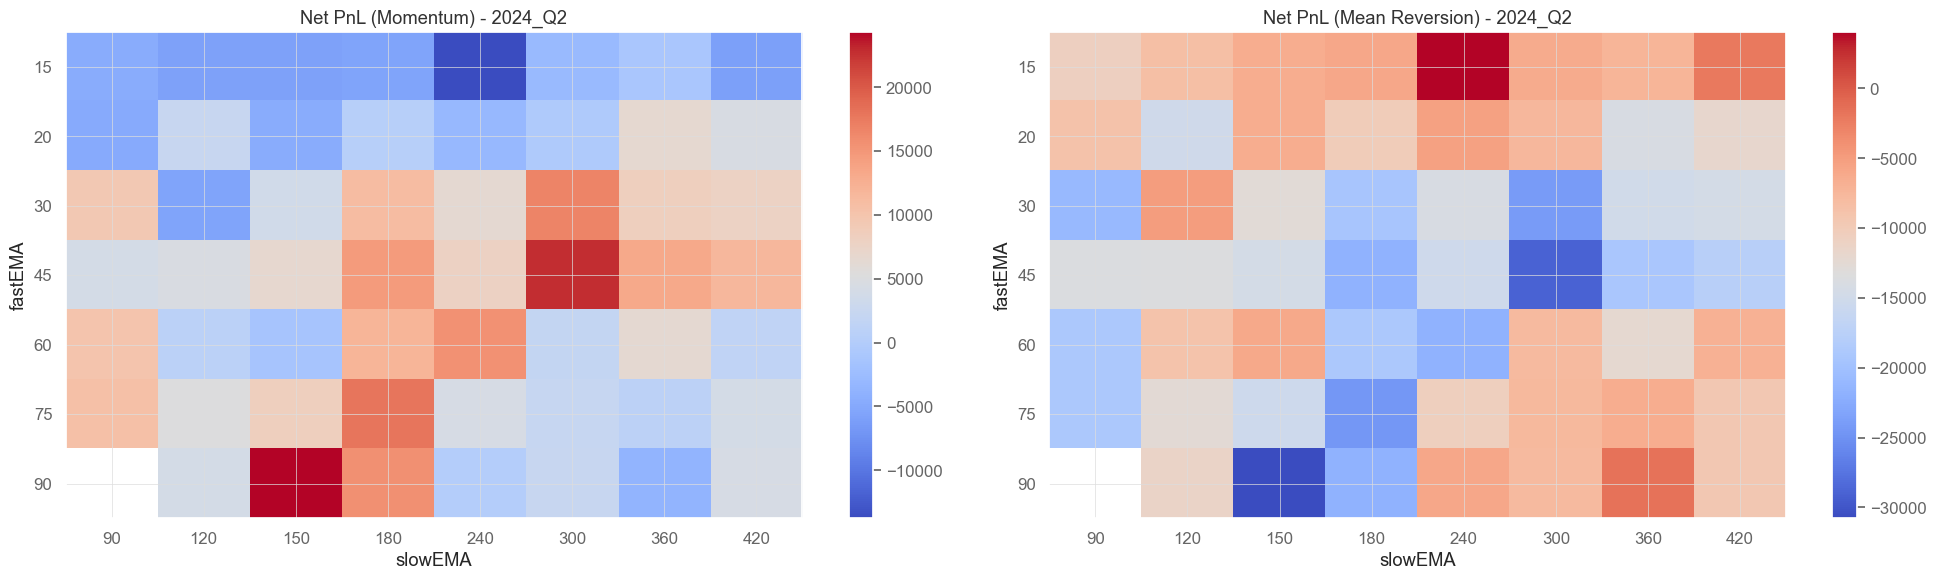

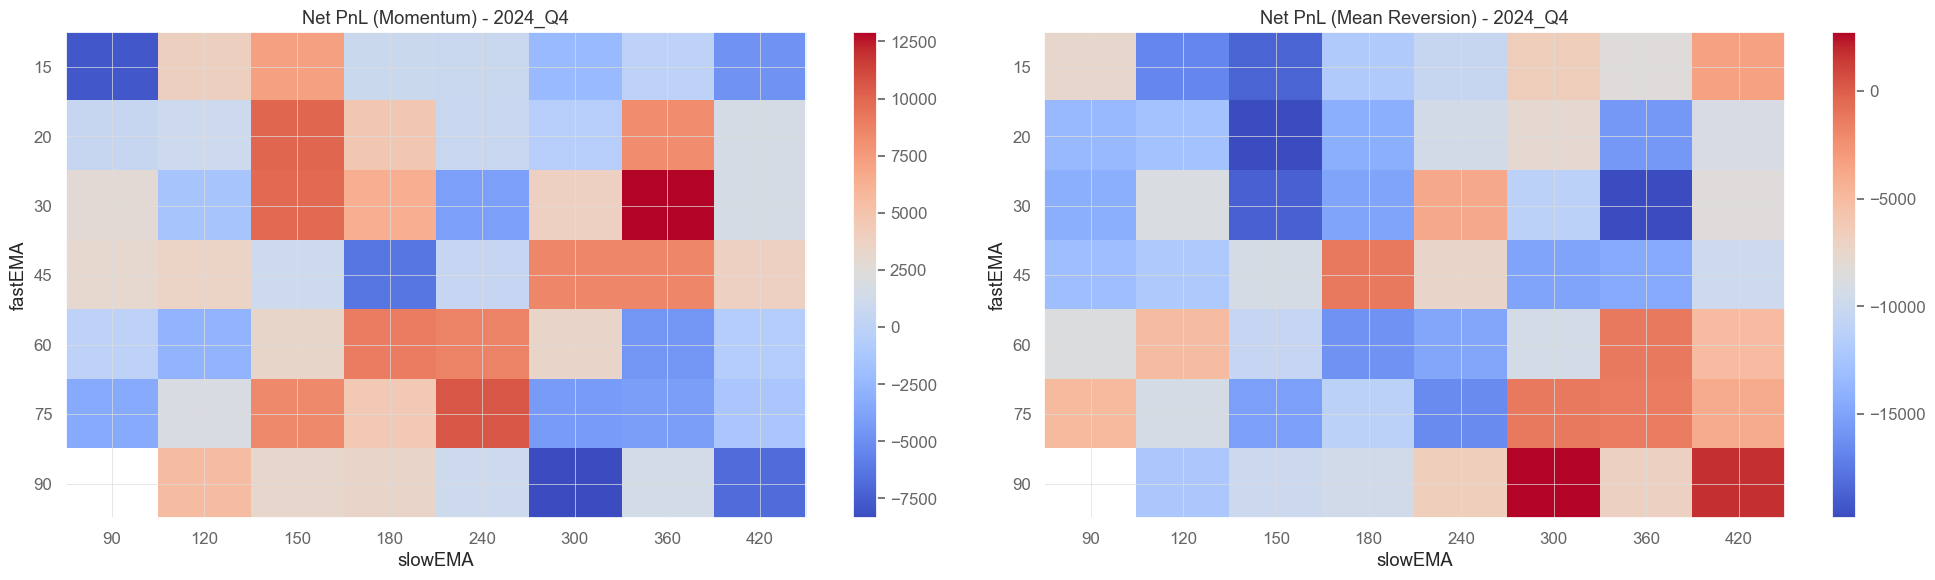

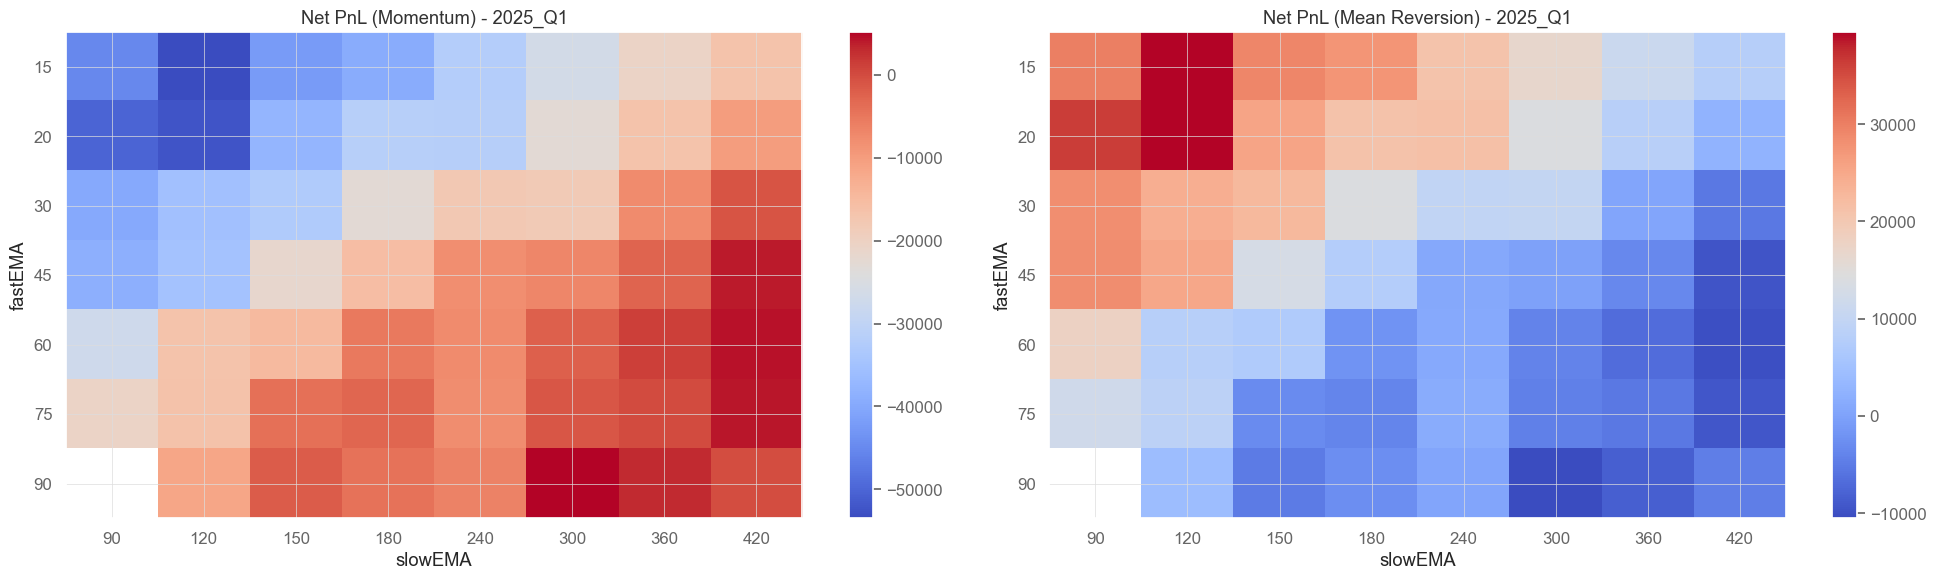

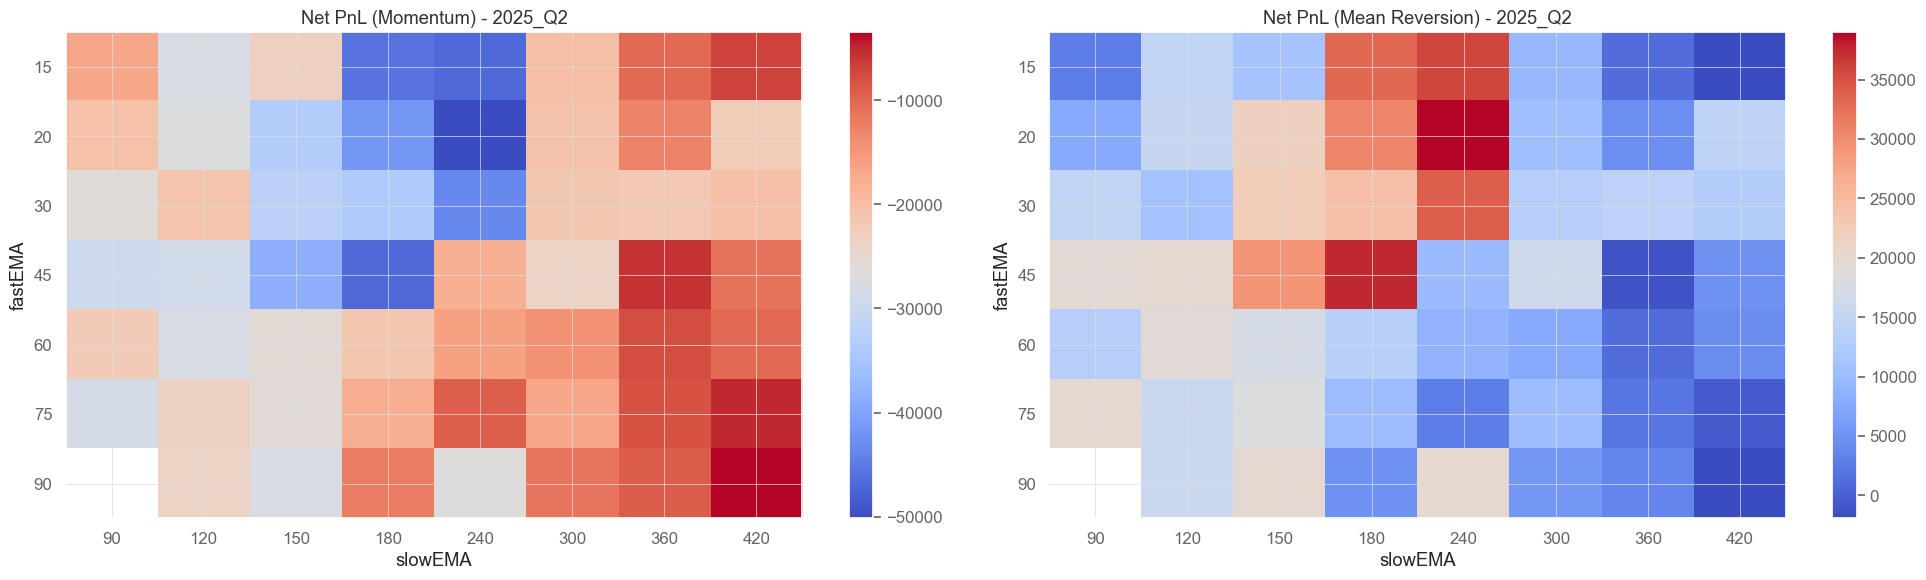

In [25]:
# Create separate heatmaps for each quarter
for quarter in quarters:
    quarter_data = summary_2MAs[summary_2MAs['quarter'] == quarter]

    # Create figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot momentum strategy heatmap
    quarter_data_pivot_mom = quarter_data.pivot(index='fastEMA', columns='slowEMA', values='net_PnL_mom')
    im1 = axes[0].imshow(quarter_data_pivot_mom.values, cmap='coolwarm', aspect='auto')
    axes[0].set_xticks(range(len(quarter_data_pivot_mom.columns)))
    axes[0].set_yticks(range(len(quarter_data_pivot_mom.index)))
    axes[0].set_xticklabels(quarter_data_pivot_mom.columns)
    axes[0].set_yticklabels(quarter_data_pivot_mom.index)
    axes[0].set_xlabel('slowEMA')
    axes[0].set_ylabel('fastEMA')
    axes[0].set_title(f'Net PnL (Momentum) - {quarter}')
    plt.colorbar(im1, ax=axes[0])

    # Plot mean reversion strategy heatmap
    quarter_data_pivot_mr = quarter_data.pivot(index='fastEMA', columns='slowEMA', values='net_PnL_mr')
    im2 = axes[1].imshow(quarter_data_pivot_mr.values, cmap='coolwarm', aspect='auto')
    axes[1].set_xticks(range(len(quarter_data_pivot_mr.columns)))
    axes[1].set_yticks(range(len(quarter_data_pivot_mr.index)))
    axes[1].set_xticklabels(quarter_data_pivot_mr.columns)
    axes[1].set_yticklabels(quarter_data_pivot_mr.index)
    axes[1].set_xlabel('slowEMA')
    axes[1].set_ylabel('fastEMA')
    axes[1].set_title(f'Net PnL (Mean Reversion) - {quarter}')
    plt.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

In [26]:
aggregated_stats_2MAs = (
    summary_2MAs
    .groupby(['fastEMA', 'slowEMA'], as_index=False)
    .agg(
        stat_mom_total=('stat_mom', 'sum'),
        stat_mr_total=('stat_mr', 'sum'),
        quarters_count=('quarter', 'nunique'),
        net_SR_mom_mean=('net_SR_mom', 'mean'),
        net_SR_mr_mean=('net_SR_mr', 'mean'),
        net_PnL_mom_total=('net_PnL_mom', 'sum'),
        net_PnL_mr_total=('net_PnL_mr', 'sum'),
        av_daily_ntrans_mean=('av_daily_ntrans', 'mean')
    )
)

In [27]:
aggregated_stats_2MAs['stat_mom_total'] = aggregated_stats_2MAs['stat_mom_total'].round(2)
aggregated_stats_2MAs['stat_mr_total'] = aggregated_stats_2MAs['stat_mr_total'].round(2)

In [28]:
aggregated_stats_2MAs
#all negative - we need to find something more interesting

fastEMA  slowEMA  stat_mom_total  stat_mr_total  quarters_count  \
0        15       90          -56.04           6.47               7   
1        15      120          -53.03           2.76               7   
2        15      150          -41.74          -1.61               7   
3        15      180          -45.58           6.37               7   
4        15      240          -36.95          -0.65               7   
5        15      300          -21.88          -6.42               7   
6        15      360          -15.47         -10.34               7   
7        15      420          -15.59          -7.97               7   
8        20       90          -48.57           1.01               7   
9        20      120          -50.84           7.42               7   
10       20      150          -36.81          -4.88               7   
11       20      180          -35.49          -1.48               7   
12       20      240          -32.63          -1.15               7   
13       20      300          -19.34          -4.98               7   
14       20      360          -11.63         -15.87               7   
15       20      420          -13.63         -13.22               7   
16       30       90          -40.64          -4.51               7   
17       30      120          -40.54           2.04               7   
18       30      150          -32.18          -5.09               7   
19       30      180          -25.50          -8.12               7   
20       30      240          -22.95          -2.92               7   
21       30      300          -13.75         -13.45               7   
22       30      360          -10.73         -18.16               7   
23       30      420           -5.61         -19.67               7   
24       45       90          -38.89          -2.16               7   
25       45      120          -36.68           0.88               7   
26       45      150          -32.05           0.17               7   
27       45      180          -28.93           0.73               7   
28       45      240          -10.55         -10.28               7   
29       45      300           -5.36         -20.43               7   
30       45      360           -3.88         -20.02               7   
31       45      420           -4.73         -23.59               7   
32       60       90          -32.72          -0.99               7   
33       60      120          -28.42          -0.71               7   
34       60      150          -25.11          -1.99               7   
35       60      180          -13.05         -12.48               7   
36       60      240           -5.80         -20.65               7   
37       60      300           -4.24         -20.03               7   
38       60      360           -2.29         -21.43               7   
39       60      420           -4.82         -20.01               7   
40       75       90          -29.79          -3.41               7   
41       75      120          -26.82          -3.17               7   
42       75      150          -16.18          -8.12               7   
43       75      180           -8.50         -14.95               7   
44       75      240           -8.09         -17.79               7   
45       75      300           -8.05         -15.08               7   
46       75      360           -2.24         -19.92               7   
47       75      420           -5.03         -17.72               7   
48       90      120          -21.25          -5.62               7   
49       90      150          -10.91         -14.04               7   
50       90      180           -7.74         -14.25               7   
51       90      240          -14.21         -10.37               7   
52       90      300           -2.78         -23.07               7   
53       90      360           -4.39         -18.30               7   
54       90      420           -9.38         -11.93               7   

    net_SR_mom_mean  net_SR

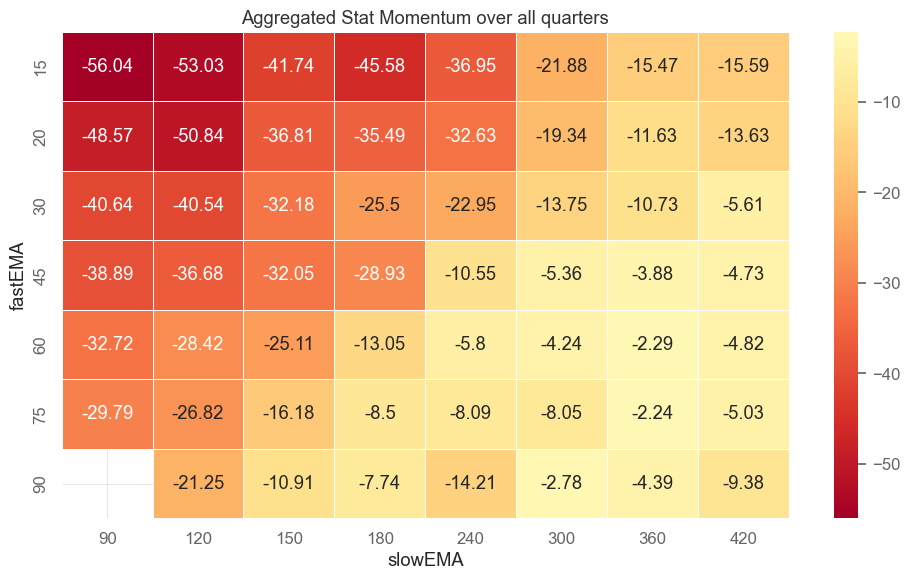

In [29]:
from functions.plot_heatmap import plot_heatmap

plot_heatmap(
    df=aggregated_stats_2MAs,
    value_col='stat_mom_total',
    index_col='fastEMA',
    columns_col='slowEMA',
    title='Aggregated Stat Momentum over all quarters',
)

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)


signalEMA_parameters = [20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240]
volat_sd_parameters = [60, 90, 120]
m_parameters = [1, 2, 3]

# create an empty DataFrame to store summary for all quarters
summary_all_breakout = pd.DataFrame()

for quarter in quarters:

    print(f'Processing quarter: {quarter}')

    data2 = pd.read_parquet(f'data/data2_{quarter}.parquet')

    # Lets set the datetime index
    data2.set_index('datetime', inplace=True)

     # assumption
    # let's create an object named "pos_flat"
    # = 1 if position has to be flat (= 0) - we do not trade
    # = 0 otherwise

    # let's fill it first with zeros
    pos_flat = np.zeros(len(data2))

    #
    breaks = (data2.index.time >= pd.to_datetime("16:41").time()) & \
          (data2.index.time <= pd.to_datetime("18:10").time())

    pos_flat[breaks] = 1

    dweek_ = data2.index.dayofweek + 1
    time_ = data2.index.time
    pos_flat[((dweek_ == 5) & (time_ > pd.to_datetime('17:00').time())) |      # end of Friday
          (dweek_ == 6) |                                                      # whole Saturday (just in case)
          ((dweek_ == 7) & (time_ <= pd.to_datetime('18:00').time()))] = 1     # beginning of Sunday


    # apply the strategy
    ##############################################################
    XAG = data2['XAG']

    # create a dataframe to store results
    # loop over different parameter combinations
    for signalEMA in signalEMA_parameters:
        print(f"signalEMA = {signalEMA}")
        for slowEMA in slowEMA_parameters:
            for volat_sd in volat_sd_parameters:
                for m in m_parameters:

                    # We calculate the appropriate EMA
                    signalEMA_values = XAG.ewm(span = signalEMA).mean().to_numpy()
                    slowEMA_values = XAG.ewm(span = slowEMA).mean().to_numpy()

                    # We calculate the standard deviation
                    volat_sd_values = XAG.rolling(window = volat_sd).std().to_numpy()

                    # Insert NaNs wherever the original price is missing
                    signalEMA_values[XAG.isna()] = np.nan
                    slowEMA_values[XAG.isna()] = np.nan
                    volat_sd_values[XAG.isna()] = np.nan

                    # Calculate position for momentum strategy
                    pos_mom = positionVB(signal = signalEMA_values,
                                     lower = slowEMA_values - m * volat_sd_values,
                                     upper = slowEMA_values + m * volat_sd_values,
                                     pos_flat = pos_flat,
                                     strategy = "mom")

                    pos_mr = -pos_mom

                    # Calculate gross pnl
                    pnl_gross_mom = np.where(np.isnan(pos_mom * XAG.diff()), 0, pos_mom * XAG.diff() * 50)
                    pnl_gross_mr = np.where(np.isnan(pos_mr * XAG.diff()), 0, pos_mr * XAG.diff() * 50)
                    # point value for XAG

                    # Calculate number of transactions
                    ntrans = np.abs(np.diff(pos_mom, prepend = 0))

                    # Calculate net pnl
                    pnl_net_mom = pnl_gross_mom - ntrans * 12  # cost $10 per transaction on XAG
                    pnl_net_mr = pnl_gross_mr - ntrans * 12  # cost $10 per transaction on XAG

                    # Aggregate to daily data
                    pnl_gross_mom = pd.Series(pnl_gross_mom)
                    pnl_gross_mom.index = XAG.index.time
                    pnl_gross_mom_d = pnl_gross_mom.groupby(XAG.index.date).sum()
                    pnl_gross_mr = pd.Series(pnl_gross_mr)
                    pnl_gross_mr.index = XAG.index.time
                    pnl_gross_mr_d = pnl_gross_mr.groupby(XAG.index.date).sum()

                    pnl_net_mom = pd.Series(pnl_net_mom)
                    pnl_net_mom.index = XAG.index.time
                    pnl_net_mom_d = pnl_net_mom.groupby(XAG.index.date).sum()
                    pnl_net_mr = pd.Series(pnl_net_mr)
                    pnl_net_mr.index = XAG.index.time
                    pnl_net_mr_d = pnl_net_mr.groupby(XAG.index.date).sum()

                    ntrans = pd.Series(ntrans)
                    ntrans.index = XAG.index.time
                    ntrans_d = ntrans.groupby(XAG.index.date).sum()

                    # Calculate Sharpe Ratio and PnL
                    gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                    net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                    gross_PnL_mom = pnl_gross_mom_d.sum()
                    net_PnL_mom = pnl_net_mom_d.sum()
                    gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                    net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                    gross_PnL_mr = pnl_gross_mr_d.sum()
                    net_PnL_mr = pnl_net_mr_d.sum()

                    av_daily_ntrans = ntrans_d.mean()

                    stat_mom = (net_SR_mom - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mom/1000)))
                    stat_mr = (net_SR_mr - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mr/1000)))
                # Collect the necessary results into one object
                    summary = pd.DataFrame({
                    'signalEMA': signalEMA,
                    'slowEMA': slowEMA,
                    'volat_sd': volat_sd,
                    'm': m,
                    'quarter': quarter,
                    'gross_SR_mom': gross_SR_mom,
                    'net_SR_mom': net_SR_mom,
                    'gross_PnL_mom': gross_PnL_mom,
                    'net_PnL_mom': net_PnL_mom,
                    'gross_SR_mr': gross_SR_mr,
                    'net_SR_mr': net_SR_mr,
                    'gross_PnL_mr': gross_PnL_mr,
                    'net_PnL_mr': net_PnL_mr,
                    'av_daily_ntrans': av_daily_ntrans,
                    'stat_mom': stat_mom,
                    'stat_mr': stat_mr
                    }, index=[0])

                # Append the results to the summary
                    summary_all_breakout = pd.concat([summary_all_breakout, summary], ignore_index=True)

Processing quarter: 2023_Q1
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2023_Q3
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2023_Q4
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2024_Q2
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2024_Q4
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2025_Q1
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2025_Q2
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90


In [32]:
summary_all_breakout["signalEMA_slowEMA"] = (
    summary_all_breakout["signalEMA"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout["slowEMA"].astype(int).astype(str).str.zfill(3)
)

summary_all_breakout["volat_sd_m"] = (
    summary_all_breakout["volat_sd"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout["m"].astype(str)
)

summary_all_breakout.head()

signalEMA  slowEMA  volat_sd  m  quarter  gross_SR_mom  net_SR_mom  \
0         20       90        60  1  2023_Q1     -1.175033  -17.353418   
1         20       90        60  2  2023_Q1     -2.931133   -6.808470   
2         20       90        60  3  2023_Q1     -1.539431   -4.167231   
3         20       90        90  1  2023_Q1     -1.731013  -16.837627   
4         20       90        90  2  2023_Q1     -1.621243   -2.554707   

   gross_PnL_mom  net_PnL_mom  gross_SR_mr  net_SR_mr  gross_PnL_mr  \
0         -99.70     -2619.70     1.175033 -25.830640         99.70   
1        -107.70      -611.70     2.931133  -8.374012        107.70   
2         -32.55      -224.55     1.539431  -5.293979         32.55   
3        -130.95     -2314.95     1.731013 -22.466162        130.95   
4          -2.75       -26.75     1.621243  -2.542958          2.75   

   net_PnL_mr  av_daily_ntrans   stat_mom    stat_mr signalEMA_slowEMA  \
0    -2420.30         2.692308 -17.193910 -23.273429           020_090   
1     -396.30         0.538462  -0.000000  -0.000000           020_090   
2     -159.45         0.205128  -0.000000  -0.000000           020_090   
3    -2053.05         2.333333 -14.552998 -16.520169           020_090   
4      -21.25         0.025641  -0.000000  -0.000000           020_090   

  volat_sd_m  
0      060_1  
1      060_2  
2      060_3  
3      090_1  
4      090_2

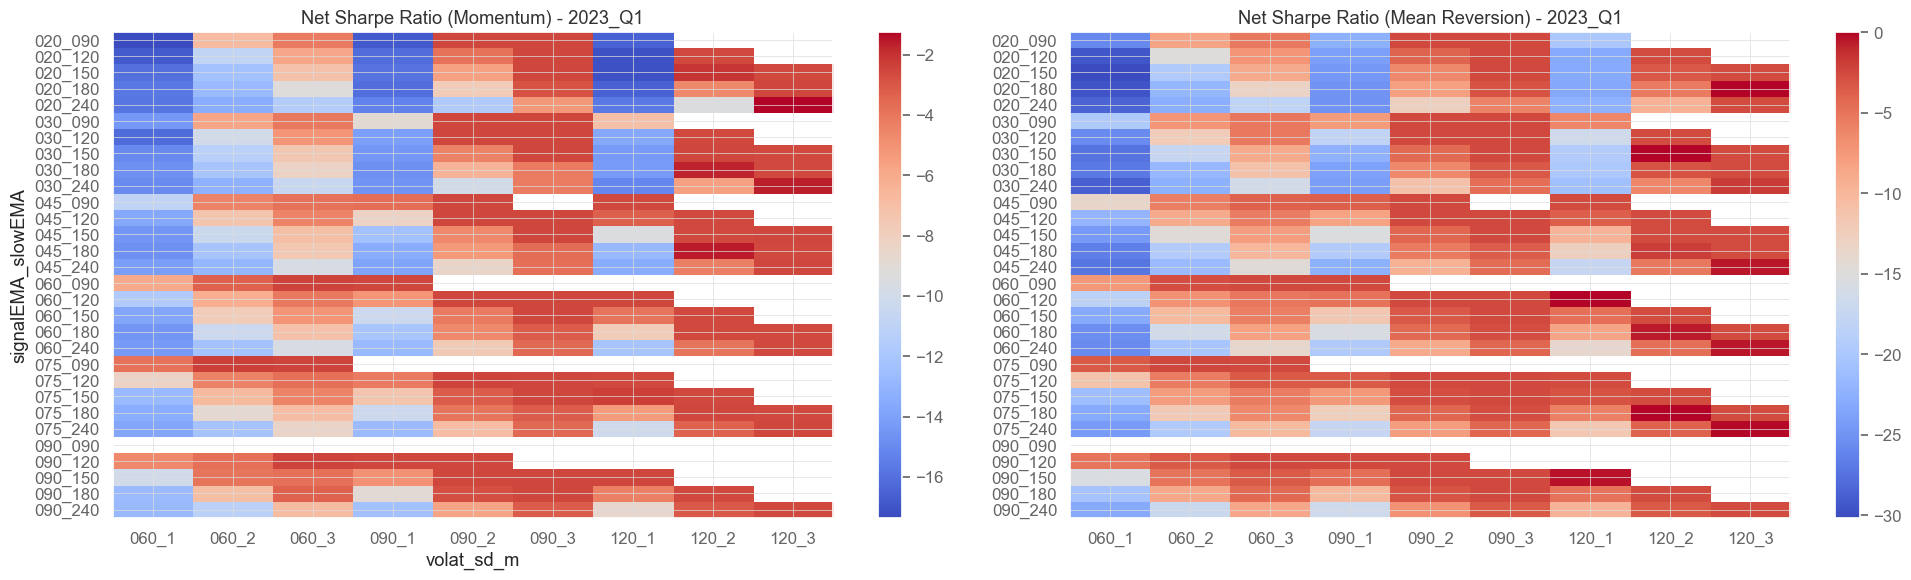

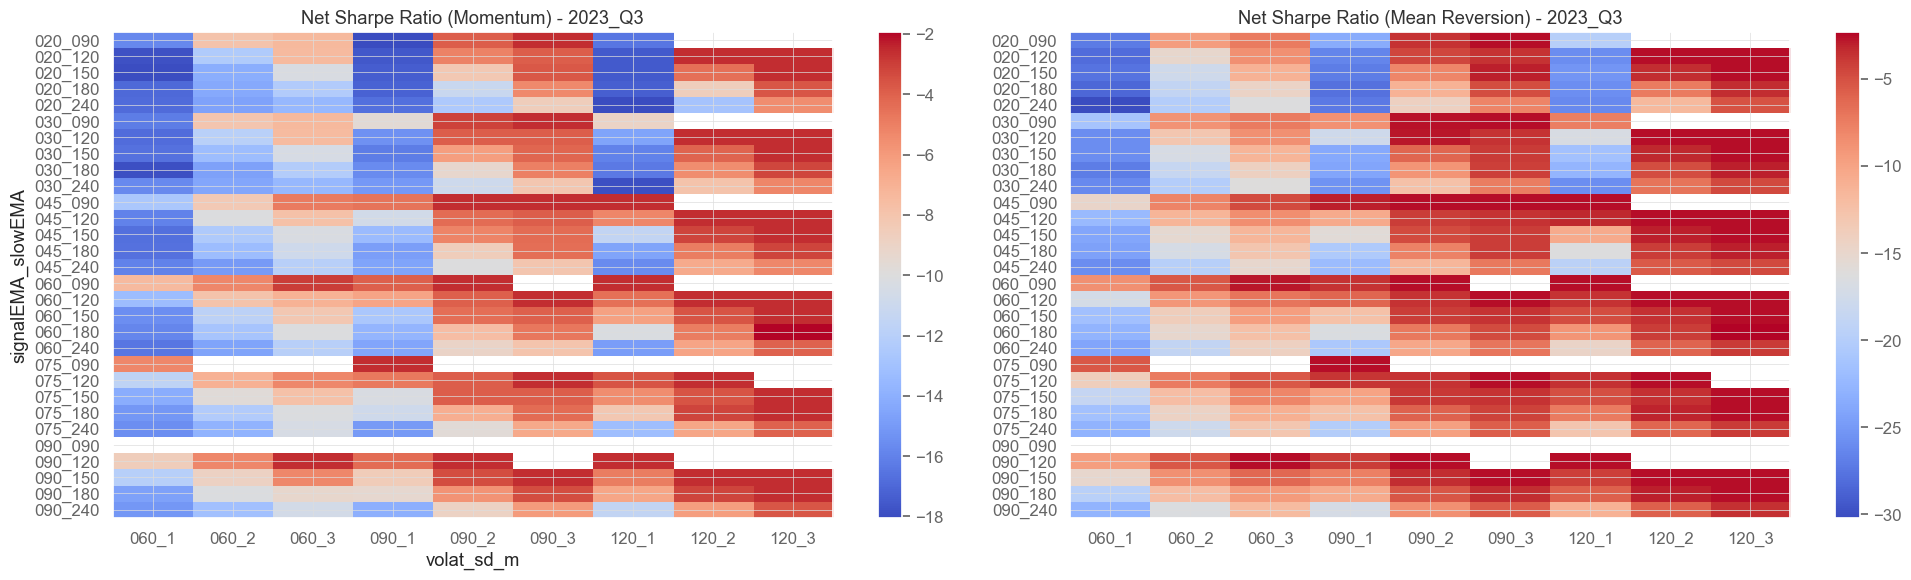

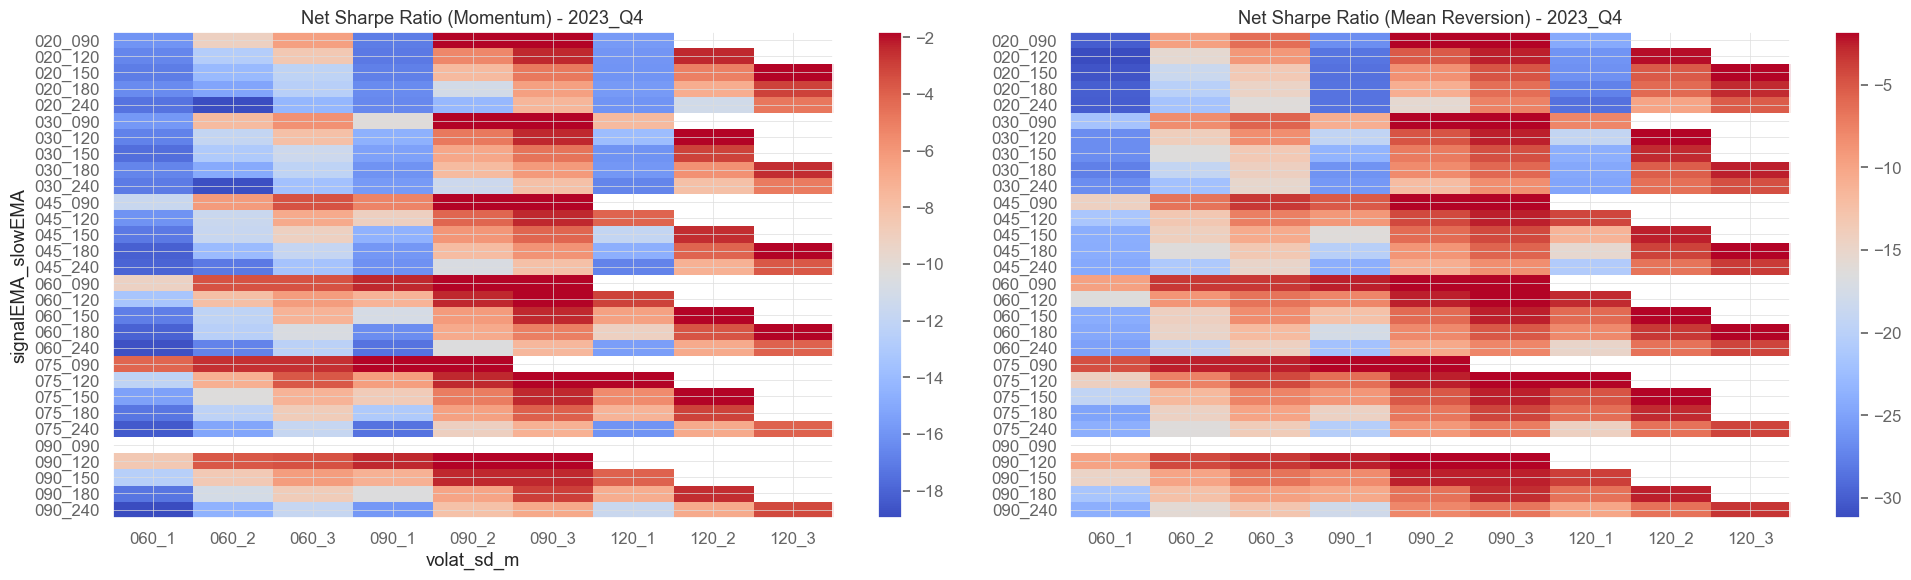

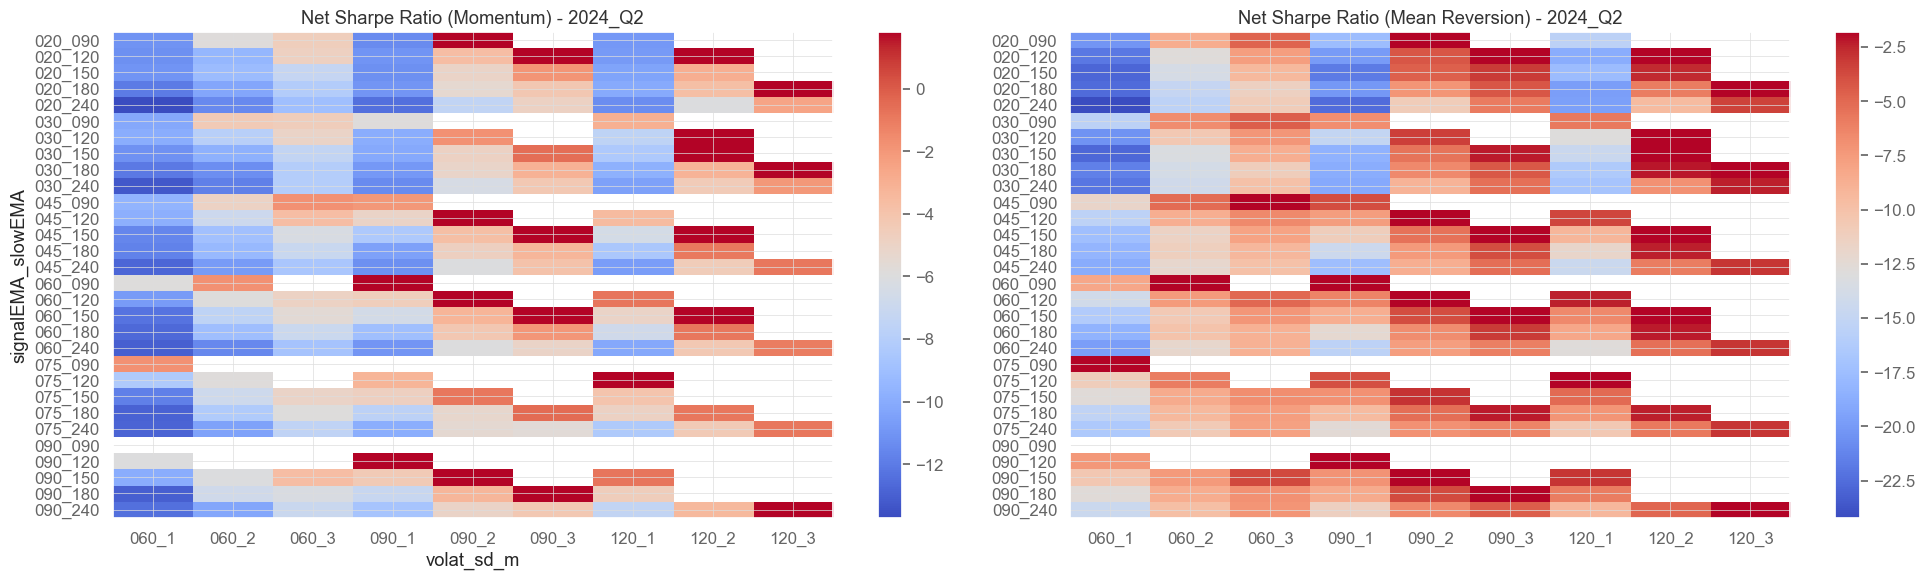

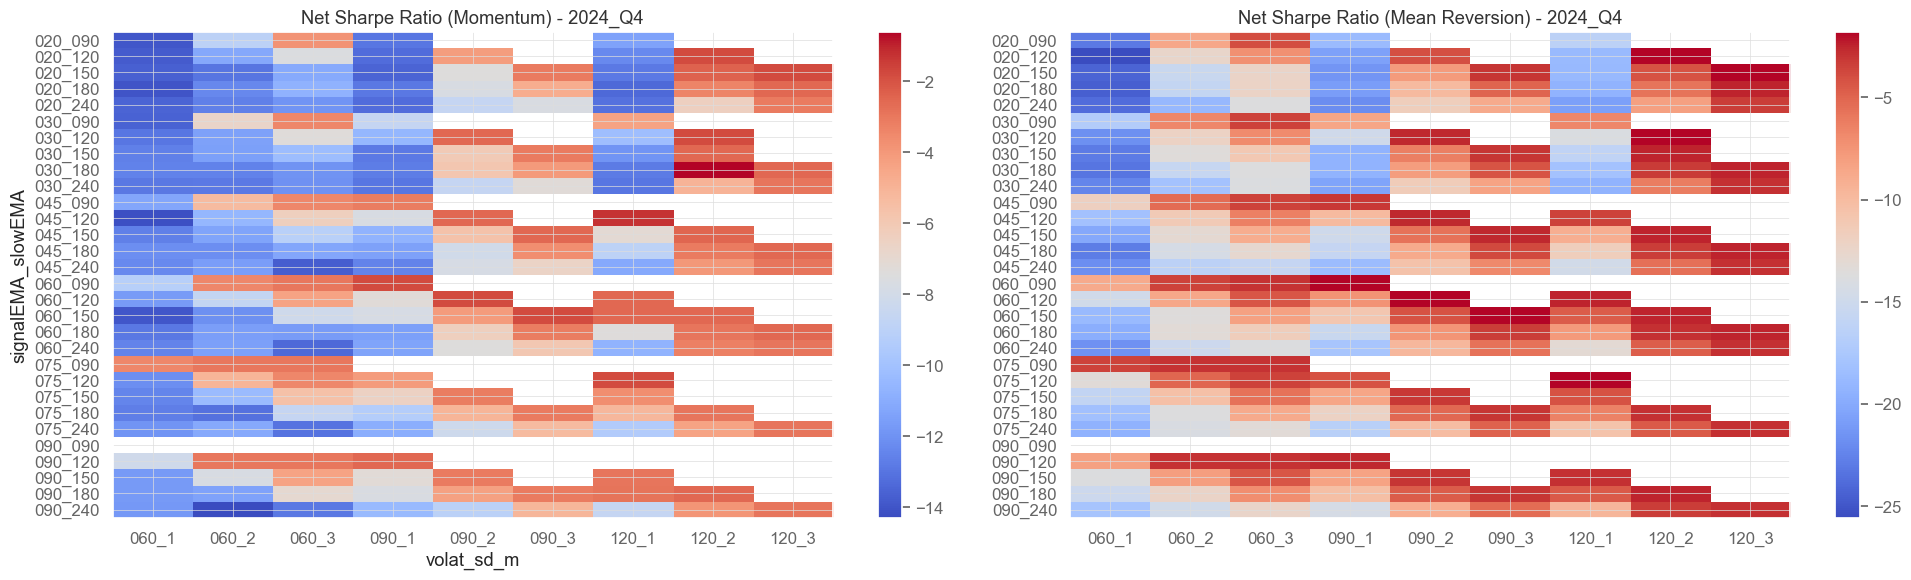

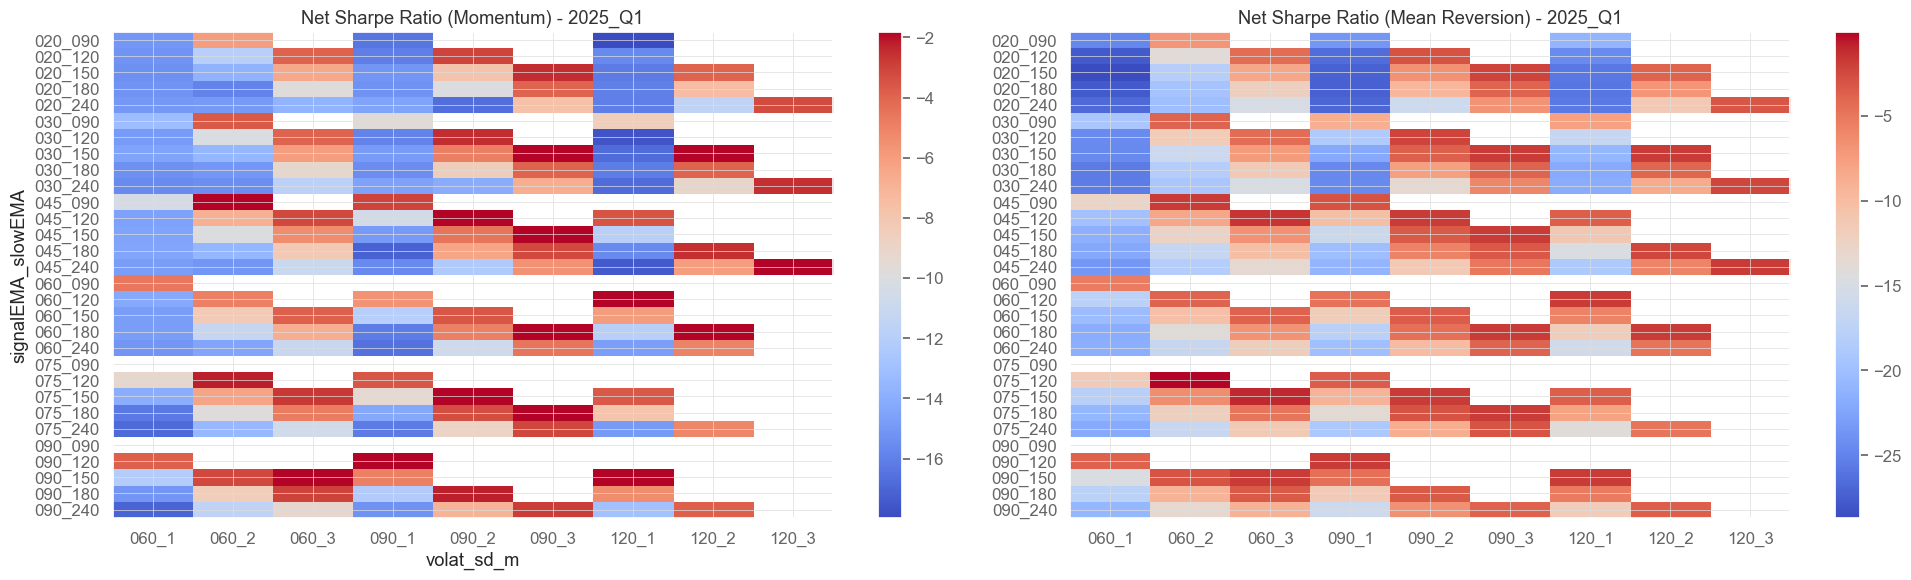

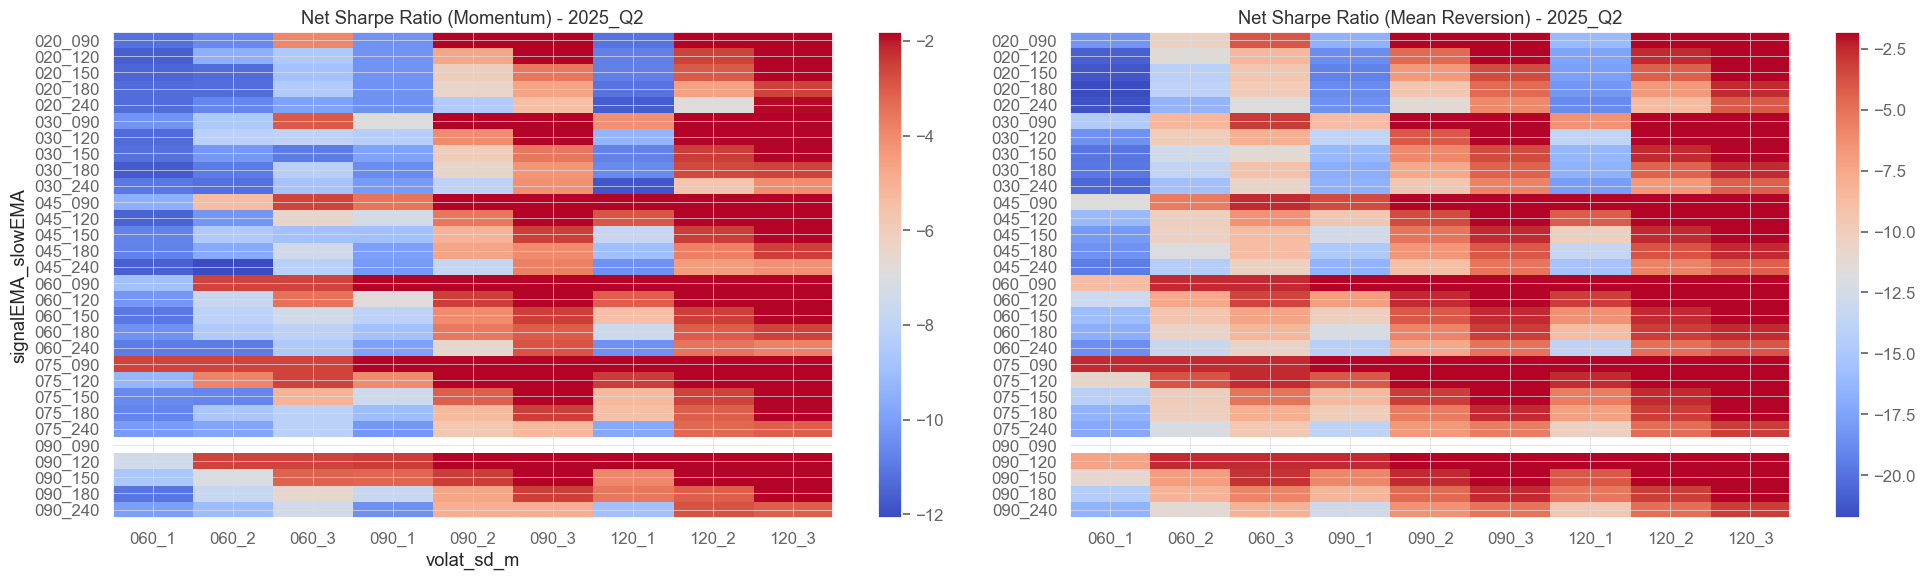

In [33]:
# Create separate heatmaps for each quarter
for quarter in quarters:
    quarter_data = summary_all_breakout[summary_all_breakout['quarter'] == quarter]

    # Create figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot momentum strategy heatmap
    quarter_data_pivot_mom = quarter_data.pivot(index='signalEMA_slowEMA', columns='volat_sd_m', values='net_SR_mom')
    im1 = axes[0].imshow(quarter_data_pivot_mom.values, cmap='coolwarm', aspect='auto')
    axes[0].set_xticks(range(len(quarter_data_pivot_mom.columns)))
    axes[0].set_yticks(range(len(quarter_data_pivot_mom.index)))
    axes[0].set_xticklabels(quarter_data_pivot_mom.columns)
    axes[0].set_yticklabels(quarter_data_pivot_mom.index)
    axes[0].set_xlabel('volat_sd_m')
    axes[0].set_ylabel('signalEMA_slowEMA')
    axes[0].set_title(f'Net Sharpe Ratio (Momentum) - {quarter}')
    plt.colorbar(im1, ax=axes[0])

    # Plot mean reversion strategy heatmap
    quarter_data_pivot_mr = quarter_data.pivot(index='signalEMA_slowEMA', columns='volat_sd_m', values='net_SR_mr')
    im2 = axes[1].imshow(quarter_data_pivot_mr.values, cmap='coolwarm', aspect='auto')
    axes[1].set_xticks(range(len(quarter_data_pivot_mr.columns)))
    axes[1].set_yticks(range(len(quarter_data_pivot_mr.index)))
    axes[1].set_xticklabels(quarter_data_pivot_mr.columns)
    axes[1].set_yticklabels(quarter_data_pivot_mr.index)
    axes[0].set_xlabel('volat_sd_m')
    axes[0].set_ylabel('signalEMA_slowEMA')
    axes[1].set_title(f'Net Sharpe Ratio (Mean Reversion) - {quarter}')
    plt.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

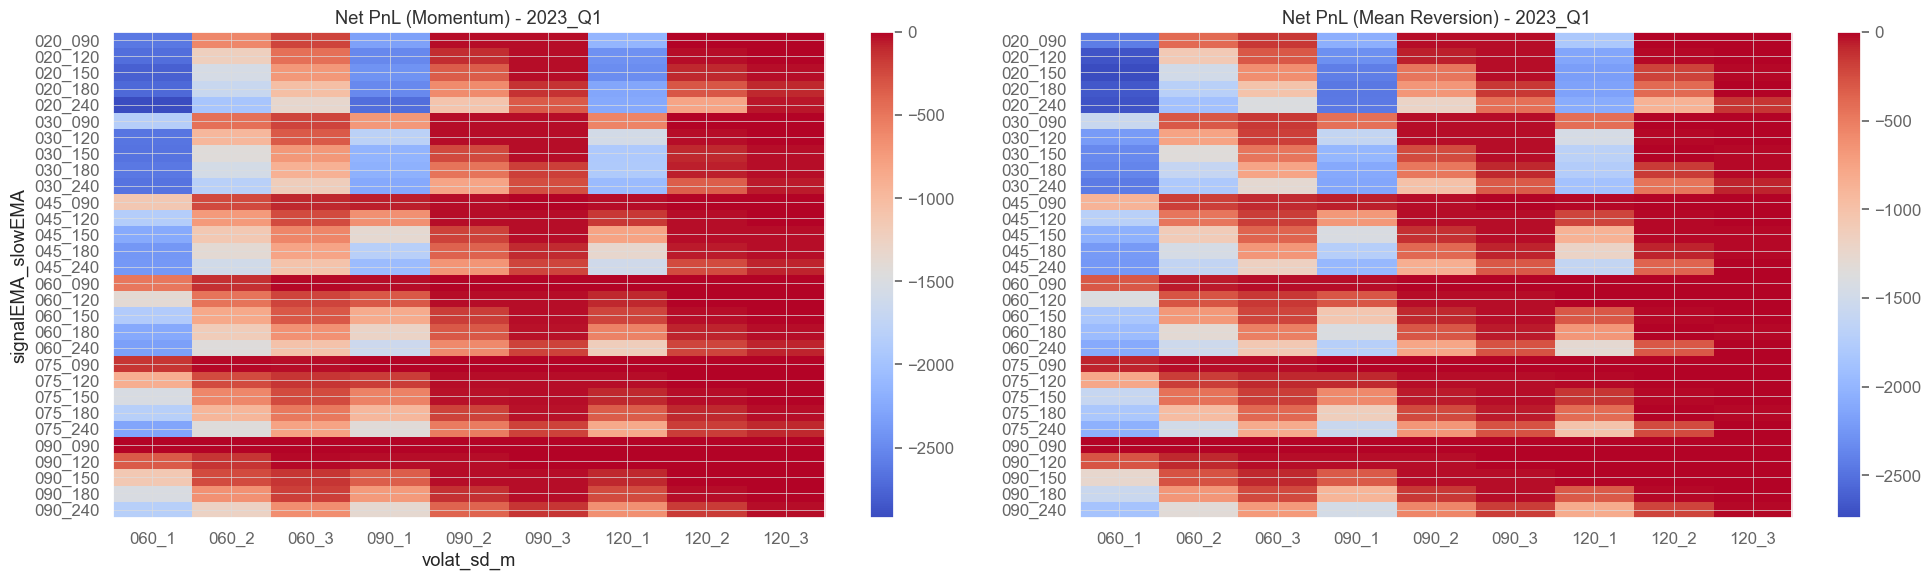

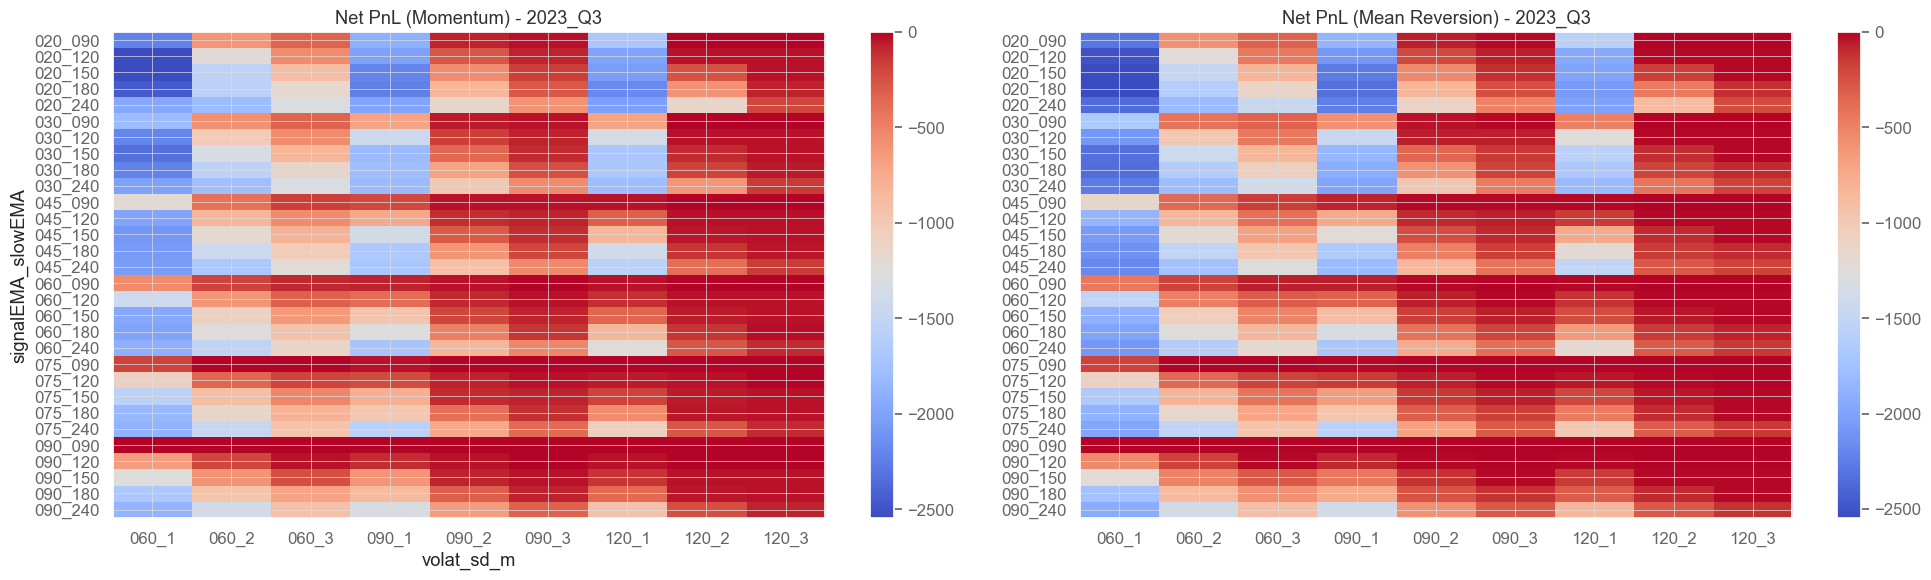

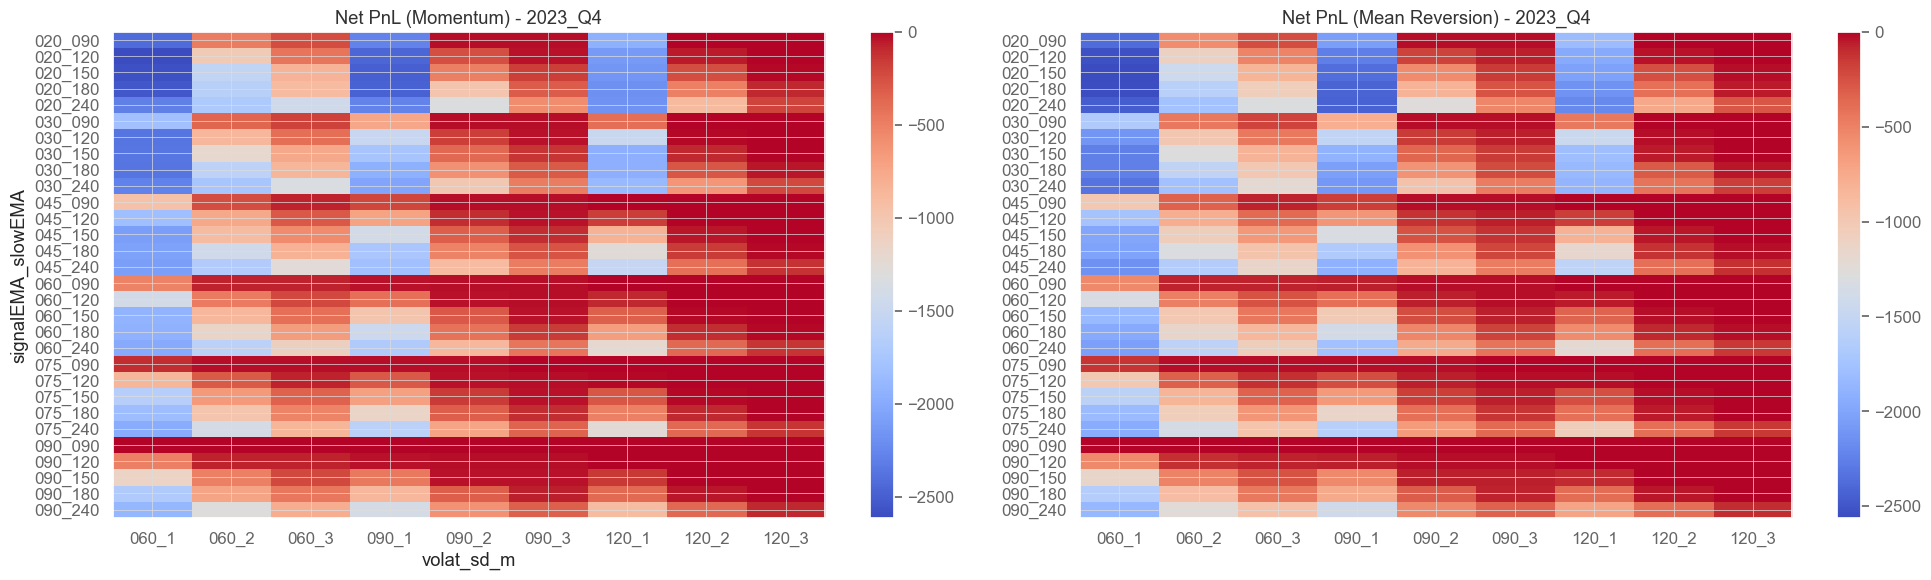

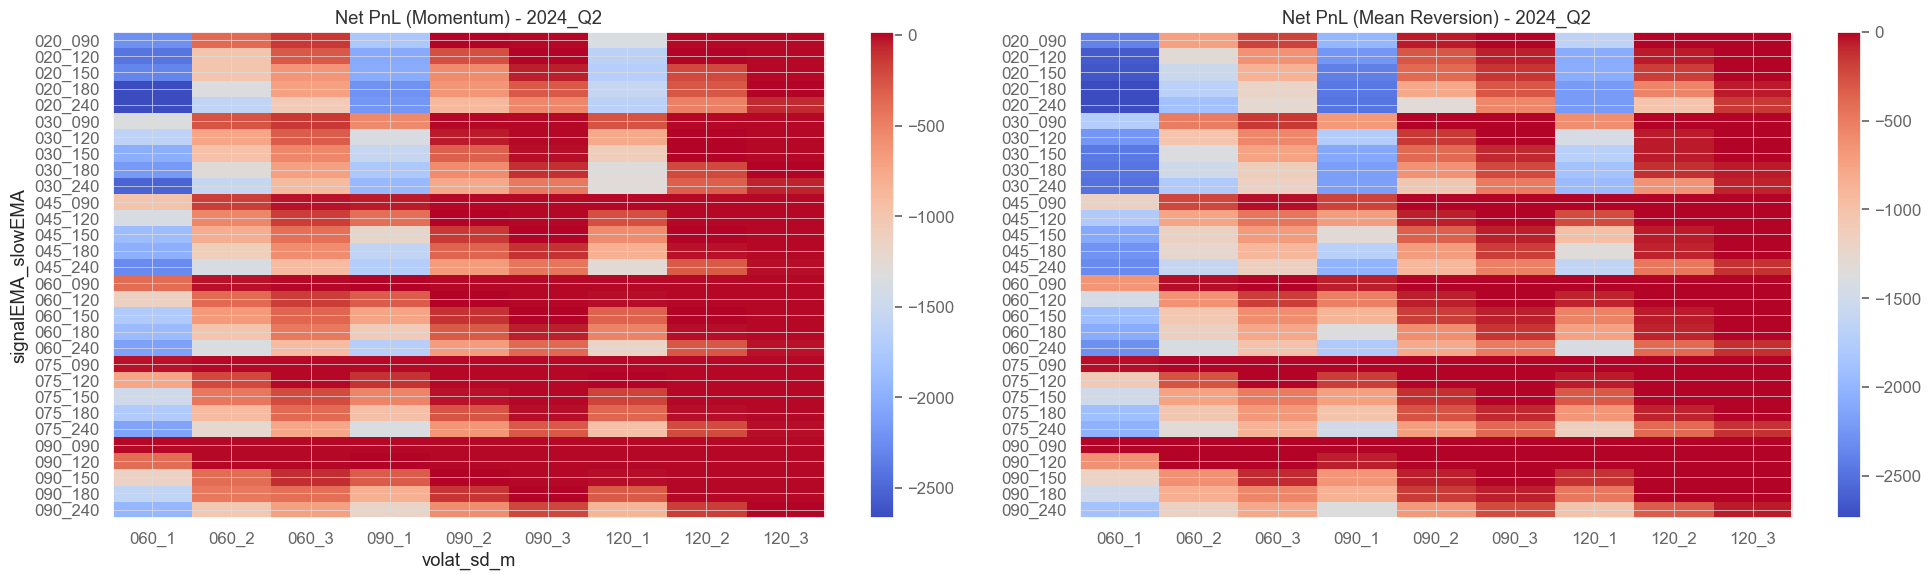

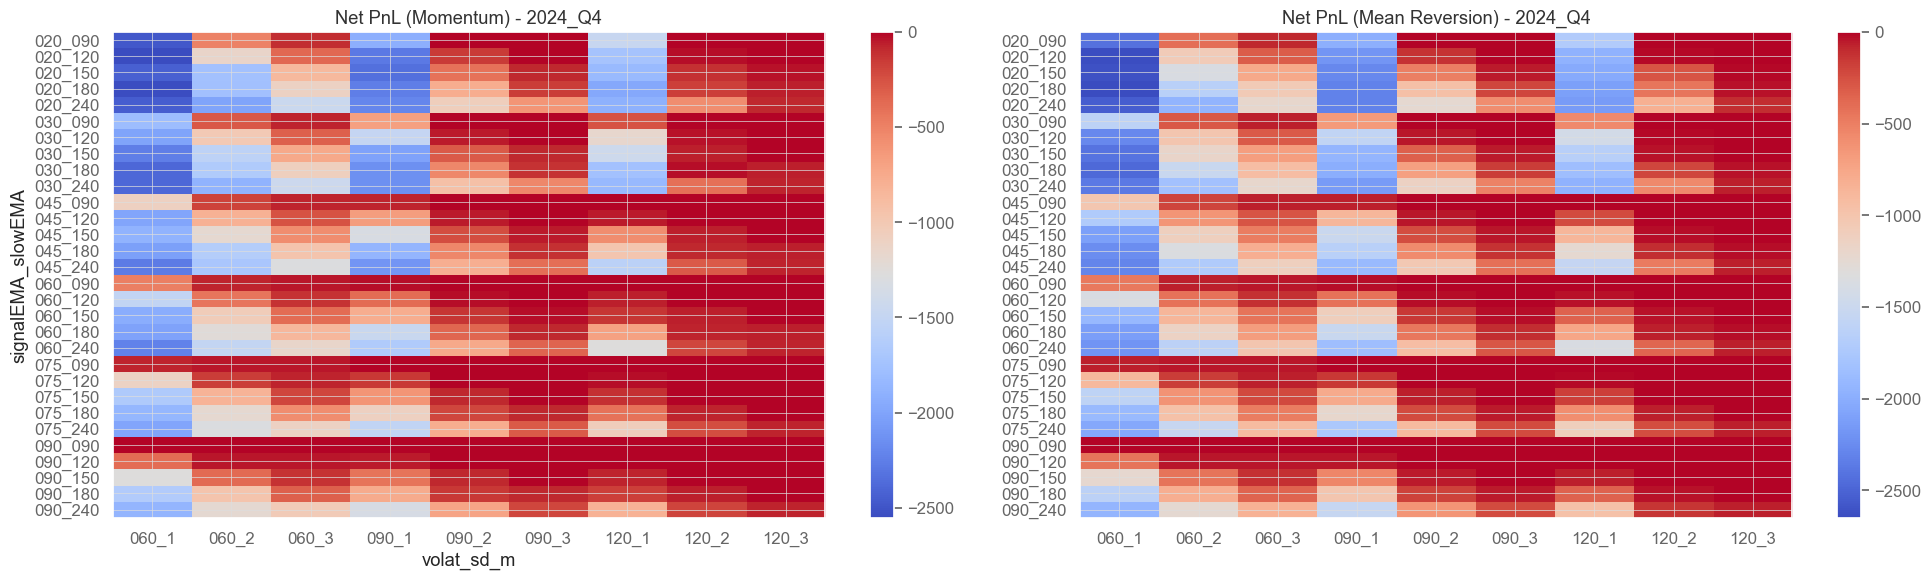

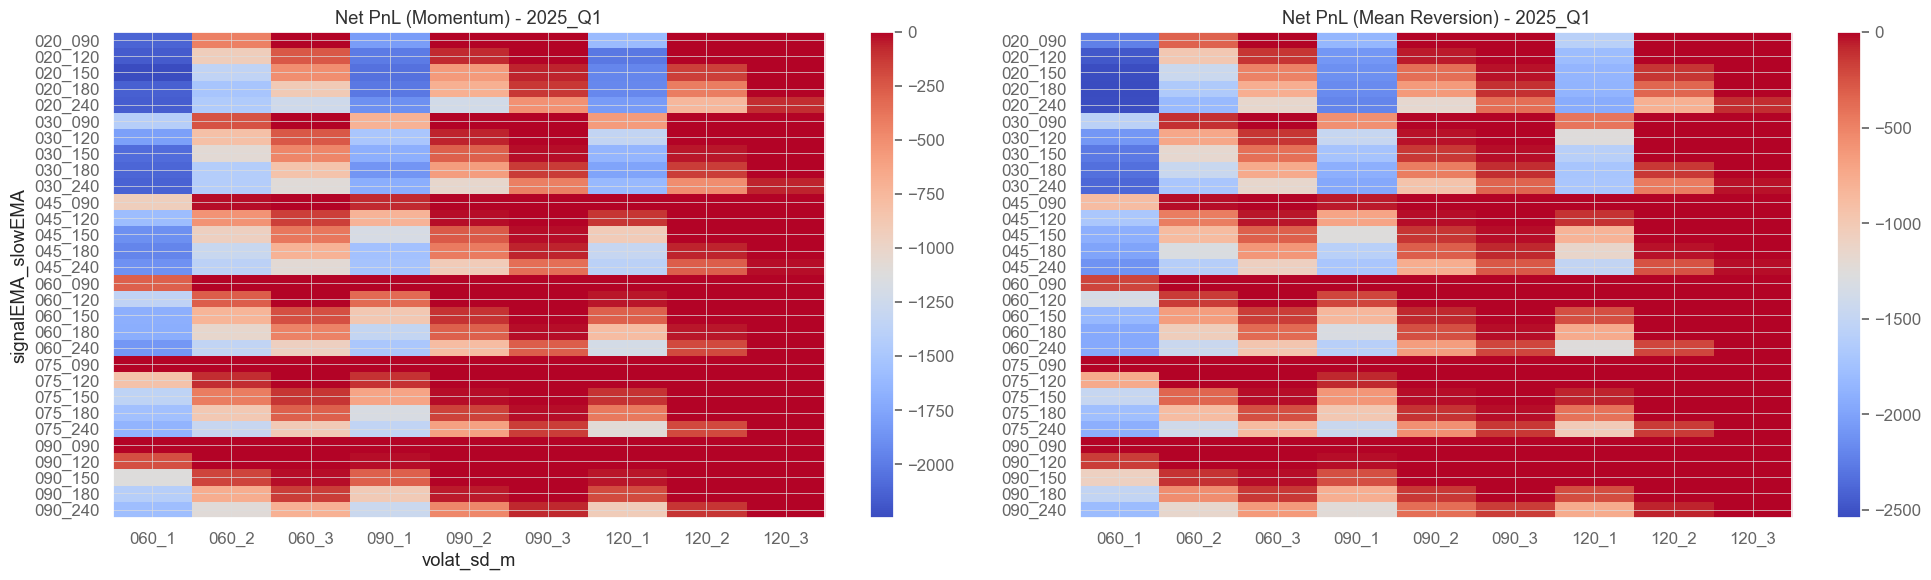

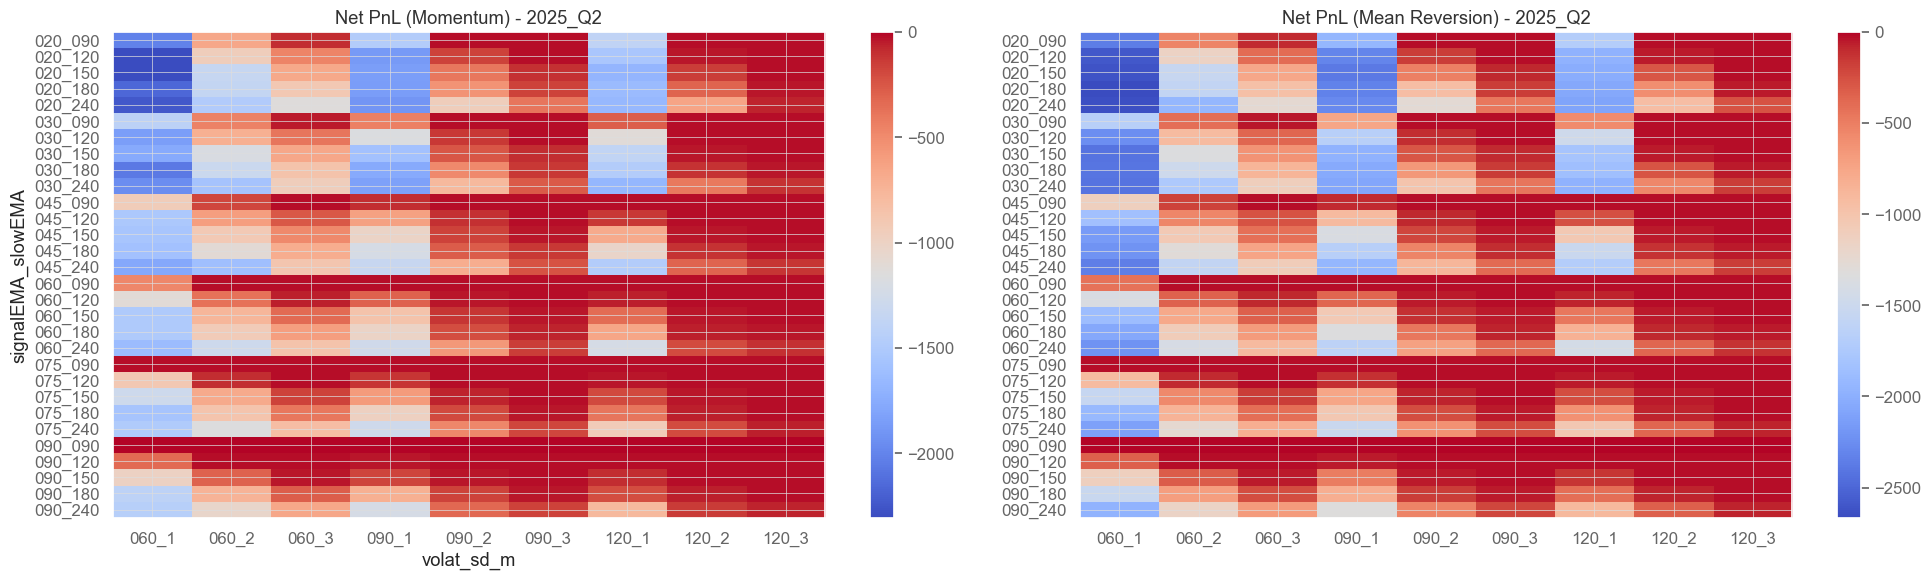

In [34]:
# Create separate heatmaps for each quarter
for quarter in quarters:
    quarter_data = summary_all_breakout[summary_all_breakout['quarter'] == quarter]

    # Create figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot momentum strategy heatmap
    quarter_data_pivot_mom = quarter_data.pivot(index='signalEMA_slowEMA', columns='volat_sd_m', values='net_PnL_mom')
    im1 = axes[0].imshow(quarter_data_pivot_mom.values, cmap='coolwarm', aspect='auto')
    axes[0].set_xticks(range(len(quarter_data_pivot_mom.columns)))
    axes[0].set_yticks(range(len(quarter_data_pivot_mom.index)))
    axes[0].set_xticklabels(quarter_data_pivot_mom.columns)
    axes[0].set_yticklabels(quarter_data_pivot_mom.index)
    axes[0].set_xlabel('volat_sd_m')
    axes[0].set_ylabel('signalEMA_slowEMA')
    axes[0].set_title(f'Net PnL (Momentum) - {quarter}')
    plt.colorbar(im1, ax=axes[0])

    # Plot mean reversion strategy heatmap
    quarter_data_pivot_mr = quarter_data.pivot(index='signalEMA_slowEMA', columns='volat_sd_m', values='net_PnL_mr')
    im2 = axes[1].imshow(quarter_data_pivot_mr.values, cmap='coolwarm', aspect='auto')
    axes[1].set_xticks(range(len(quarter_data_pivot_mr.columns)))
    axes[1].set_yticks(range(len(quarter_data_pivot_mr.index)))
    axes[1].set_xticklabels(quarter_data_pivot_mr.columns)
    axes[1].set_yticklabels(quarter_data_pivot_mr.index)
    axes[0].set_xlabel('volat_sd_m')
    axes[0].set_ylabel('signalEMA_slowEMA')
    axes[1].set_title(f'Net PnL (Mean Reversion) - {quarter}')
    plt.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

In [35]:
aggregated_stats_breakout = (
    summary_all_breakout
    .groupby(['signalEMA_slowEMA', 'volat_sd_m'], as_index=False)
    .agg(
        stat_mom_total=('stat_mom', 'sum'),
        stat_mr_total=('stat_mr', 'sum'),
        quarters_count=('quarter', 'nunique'),
        net_SR_mom_mean=('net_SR_mom', 'mean'),
        net_SR_mr_mean=('net_SR_mr', 'mean'),
        net_PnL_mom_total=('net_PnL_mom', 'sum'),
        net_PnL_mr_total=('net_PnL_mr', 'sum'),
        av_daily_ntrans_mean=('av_daily_ntrans', 'mean')
    )
)

aggregated_stats_breakout['stat_mom_total'] = aggregated_stats_breakout['stat_mom_total'].round(2)
aggregated_stats_breakout['stat_mr_total'] = aggregated_stats_breakout['stat_mr_total'].round(2)

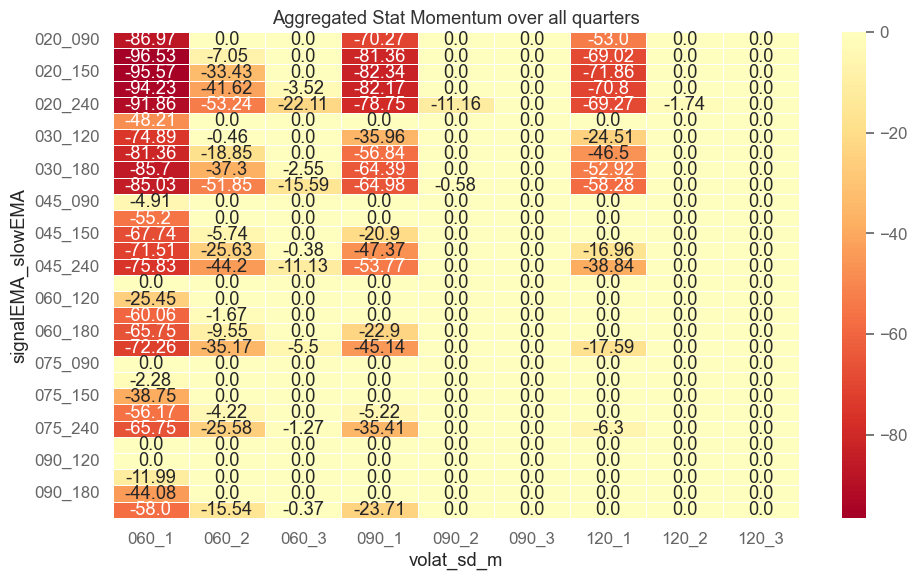

In [36]:
plot_heatmap(
    df=aggregated_stats_breakout,
    value_col='stat_mom_total',
    index_col='signalEMA_slowEMA',
    columns_col='volat_sd_m',
    title='Aggregated Stat Momentum over all quarters')

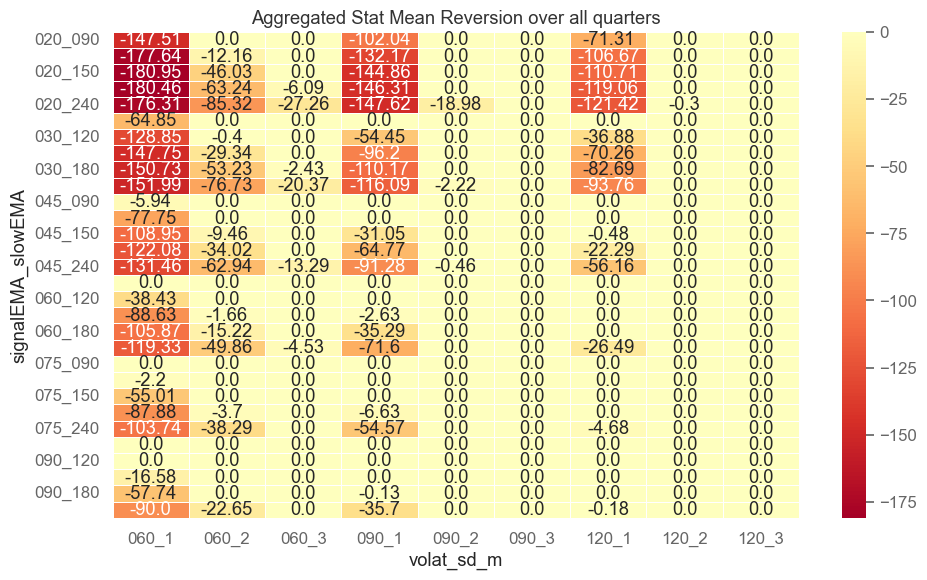

In [38]:
plot_heatmap(
    df=aggregated_stats_breakout,
    value_col='stat_mr_total',
    index_col='signalEMA_slowEMA',
    columns_col='volat_sd_m',
    title='Aggregated Stat Mean Reversion over all quarters')

In [40]:
def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)


fastEMA_parameters = [15, 20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240, 300, 360, 420]

# create an empty DataFrame to store summary for all quarters
summary_2MAs_stoploss = pd.DataFrame()

for quarter in quarters:

    print(f'Processing quarter: {quarter}')

    data2 = pd.read_parquet(f'data/data2_{quarter}.parquet')

    # Lets set the datetime index
    data2.set_index('datetime', inplace=True)

    # assumption
    # let's create an object named "pos_flat"
    # = 1 if position has to be flat (= 0) - we do not trade
    # = 0 otherwise

    # let's fill it first with zeros
    pos_flat = np.zeros(len(data2))

    #
    breaks = (data2.index.time >= pd.to_datetime("16:41").time()) & \
          (data2.index.time <= pd.to_datetime("18:10").time())

    pos_flat[breaks] = 1

    dweek_ = data2.index.dayofweek + 1
    time_ = data2.index.time
    pos_flat[((dweek_ == 5) & (time_ > pd.to_datetime('17:00').time())) |      # end of Friday
          (dweek_ == 6) |                                                      # whole Saturday (just in case)
          ((dweek_ == 7) & (time_ <= pd.to_datetime('18:00').time()))] = 1     # beginning of Sunday

    # apply the strategy
    ##############################################################
    XAG = data2['XAG']

    for fastEMA in fastEMA_parameters:
        for slowEMA in slowEMA_parameters:

            # ensure that fastEMA is less than slowEMA
            if fastEMA >= slowEMA:
                continue

            print(f"  fastEMA = {fastEMA}, slowEMA = {slowEMA}")

            # We calculate the appropriate EMA
            fastEMA_values = XAG.ewm(span=fastEMA).mean()
            slowEMA_values = XAG.ewm(span=slowEMA).mean()

            # Insert NaNs wherever the original price is missing
            fastEMA_values[data2['XAG'].isna()] = np.nan
            slowEMA_values[data2['XAG'].isna()] = np.nan

            # Calculate position for momentum strategy
            cond2b_mom_long = fastEMA_values.shift(1) > slowEMA_values.shift(1)

            # let's add filters that check for the presence of NaN values
            fastEMA_nonmiss = fastEMA_values.shift(1).notna()
            slowEMA_nonmiss = slowEMA_values.shift(1).notna()

            # Now we can add these conditions to our strategies
            # if any of the values is missing,
            # we cannot make a position decision

            pos_mom = np.where(fastEMA_nonmiss & slowEMA_nonmiss,
                               np.where(cond2b_mom_long, 1, -1),
                               np.nan)
            pos_mr = -pos_mom

            # Set position to 0 where pos_flat is 1
            pos_mom[pos_flat == 1] = 0
            pos_mr[pos_flat == 1] = 0

            # Calculate gross pnl
            pnl_gross_mom = np.where(np.isnan(pos_mom * data2["XAG"].diff()), 0, pos_mom * data2["XAG"].diff() * 5000)
            pnl_gross_mr = np.where(np.isnan(pos_mr * data2["XAG"].diff()), 0, pos_mr * data2["XAG"].diff() * 5000)
            # point value for SP

            # Add stop loss condition
            # Calculate cumulative PnL for each day and apply stop loss
            pnl_gross_mom_series = pd.Series(pnl_gross_mom, index=data2.index)
            pnl_gross_mr_series = pd.Series(pnl_gross_mr, index=data2.index)

            # Define stop loss threshold (e.g., -1000 per day)
            stop_loss_threshold = -1000

            # Calculate cumulative daily PnL
            daily_cumul_pnl_mom = pnl_gross_mom_series.groupby(data2.index.date).cumsum()
            daily_cumul_pnl_mr = pnl_gross_mr_series.groupby(data2.index.date).cumsum()

            # Create stop loss mask (stop trading for rest of day if threshold hit)
            stop_loss_triggered_mom = (daily_cumul_pnl_mom <= stop_loss_threshold).groupby(data2.index.date).cummax()
            stop_loss_triggered_mr = (daily_cumul_pnl_mr <= stop_loss_threshold).groupby(data2.index.date).cummax()

            # Apply stop loss by setting position to 0 after trigger
            pos_mom_sl = pos_mom.copy()
            pos_mom_sl[stop_loss_triggered_mom] = 0
            pos_mr_sl = pos_mr.copy()
            pos_mr_sl[stop_loss_triggered_mr] = 0

            # Recalculate PnL with stop loss
            pnl_gross_mom = np.where(np.isnan(pos_mom_sl * data2['XAG'].diff()), 0, pos_mom_sl * data2['XAG'].diff() * 5000)
            pnl_gross_mr = np.where(np.isnan(pos_mr_sl * data2['XAG'].diff()), 0, pos_mr_sl * data2['XAG'].diff() * 5000)

            # Calculate number of transactions
            ntrans = np.abs(np.diff(pos_mom, prepend=0))

            # Calculate net pnl
            pnl_net_mom = pnl_gross_mom - ntrans * 10  # cost $12 per transaction
            pnl_net_mr = pnl_gross_mr - ntrans * 10  # cost $12 per transaction

            # Aggregate to daily data
            pnl_gross_mom = pd.Series(pnl_gross_mom)
            pnl_gross_mom.index = data2['XAG'].index.time
            pnl_gross_mom_d = pnl_gross_mom.groupby(data2['XAG'].index.date).sum()
            pnl_gross_mr = pd.Series(pnl_gross_mr)
            pnl_gross_mr.index = data2['XAG'].index.time
            pnl_gross_mr_d = pnl_gross_mr.groupby(data2['XAG'].index.date).sum()

            pnl_net_mom = pd.Series(pnl_net_mom)
            pnl_net_mom.index = data2['XAG'].index.time
            pnl_net_mom_d = pnl_net_mom.groupby(data2['XAG'].index.date).sum()
            pnl_net_mr = pd.Series(pnl_net_mr)
            pnl_net_mr.index = data2['XAG'].index.time
            pnl_net_mr_d = pnl_net_mr.groupby(data2['XAG'].index.date).sum()

            ntrans = pd.Series(ntrans)
            ntrans.index = data2['XAG'].index.time
            ntrans_d = ntrans.groupby(data2['XAG'].index.date).sum()

            # Calculate Sharpe Ratio and PnL
            gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
            net_SR_mom = mySR(pnl_net_mom_d, scale=252)
            gross_PnL_mom = pnl_gross_mom_d.sum()
            net_PnL_mom = pnl_net_mom_d.sum()
            gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
            net_SR_mr = mySR(pnl_net_mr_d, scale=252)
            gross_PnL_mr = pnl_gross_mr_d.sum()
            net_PnL_mr = pnl_net_mr_d.sum()

            av_daily_ntrans = ntrans_d.mean()
            stat_mom = (net_SR_mom - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mom / 1000)))
            stat_mr = (net_SR_mr - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mr / 1000)))

            # Collect necessary results into one object
            summary = pd.DataFrame({
                'fastEMA': fastEMA,
                'slowEMA': slowEMA,
                'quarter': quarter,
                'gross_SR_mom': gross_SR_mom,
                'net_SR_mom': net_SR_mom,
                'gross_PnL_mom': gross_PnL_mom,
                'net_PnL_mom': net_PnL_mom,
                'gross_SR_mr': gross_SR_mr,
                'net_SR_mr': net_SR_mr,
                'gross_PnL_mr': gross_PnL_mr,
                'net_PnL_mr': net_PnL_mr,
                'av_daily_ntrans': av_daily_ntrans,
                'stat_mom': stat_mom,
                'stat_mr': stat_mr
            }, index=[0])

            # Append results to the summary
            summary_2MAs_stoploss = pd.concat([summary_2MAs_stoploss, summary], ignore_index=True)

Processing quarter: 2023_Q1
  fastEMA = 15, slowEMA = 90
  fastEMA = 15, slowEMA = 120
  fastEMA = 15, slowEMA = 150
  fastEMA = 15, slowEMA = 180
  fastEMA = 15, slowEMA = 240
  fastEMA = 15, slowEMA = 300
  fastEMA = 15, slowEMA = 360
  fastEMA = 15, slowEMA = 420
  fastEMA = 20, slowEMA = 90
  fastEMA = 20, slowEMA = 120
  fastEMA = 20, slowEMA = 150
  fastEMA = 20, slowEMA = 180
  fastEMA = 20, slowEMA = 240
  fastEMA = 20, slowEMA = 300
  fastEMA = 20, slowEMA = 360
  fastEMA = 20, slowEMA = 420
  fastEMA = 30, slowEMA = 90
  fastEMA = 30, slowEMA = 120
  fastEMA = 30, slowEMA = 150
  fastEMA = 30, slowEMA = 180
  fastEMA = 30, slowEMA = 240
  fastEMA = 30, slowEMA = 300
  fastEMA = 30, slowEMA = 360
  fastEMA = 30, slowEMA = 420
  fastEMA = 45, slowEMA = 90
  fastEMA = 45, slowEMA = 120
  fastEMA = 45, slowEMA = 150
  fastEMA = 45, slowEMA = 180
  fastEMA = 45, slowEMA = 240
  fastEMA = 45, slowEMA = 300
  fastEMA = 45, slowEMA = 360
  fastEMA = 45, slowEMA = 420
  fastEMA = 60, 

In [41]:
aggregated_stats_2MAs_stoploss = (
    summary_2MAs_stoploss
    .groupby(['fastEMA', 'slowEMA'], as_index=False)
    .agg(
        stat_mom_total=('stat_mom', 'sum'),
        stat_mr_total=('stat_mr', 'sum'),
        quarters_count=('quarter', 'nunique'),
        net_SR_mom_mean=('net_SR_mom', 'mean'),
        net_SR_mr_mean=('net_SR_mr', 'mean'),
        net_PnL_mom_total=('net_PnL_mom', 'sum'),
        net_PnL_mr_total=('net_PnL_mr', 'sum'),
        av_daily_ntrans_mean=('av_daily_ntrans', 'mean')
    )
)

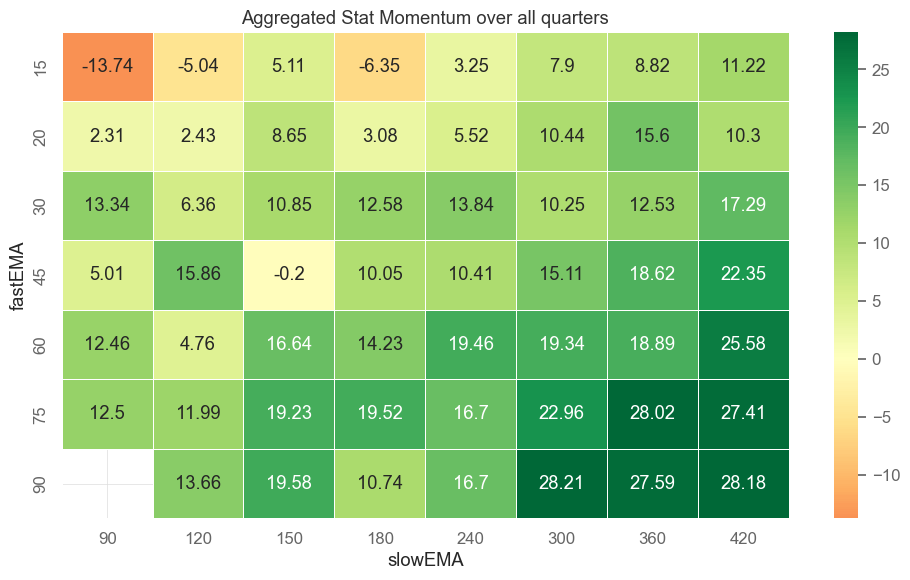

In [42]:

aggregated_stats_2MAs_stoploss['stat_mom_total'] = aggregated_stats_2MAs_stoploss['stat_mom_total'].round(2)
aggregated_stats_2MAs_stoploss['stat_mr_total'] = aggregated_stats_2MAs_stoploss['stat_mr_total'].round(2)

plot_heatmap(
    df=aggregated_stats_2MAs_stoploss,
    value_col='stat_mom_total',
    index_col='fastEMA',
    columns_col='slowEMA',
    title='Aggregated Stat Momentum over all quarters')

#a lot better


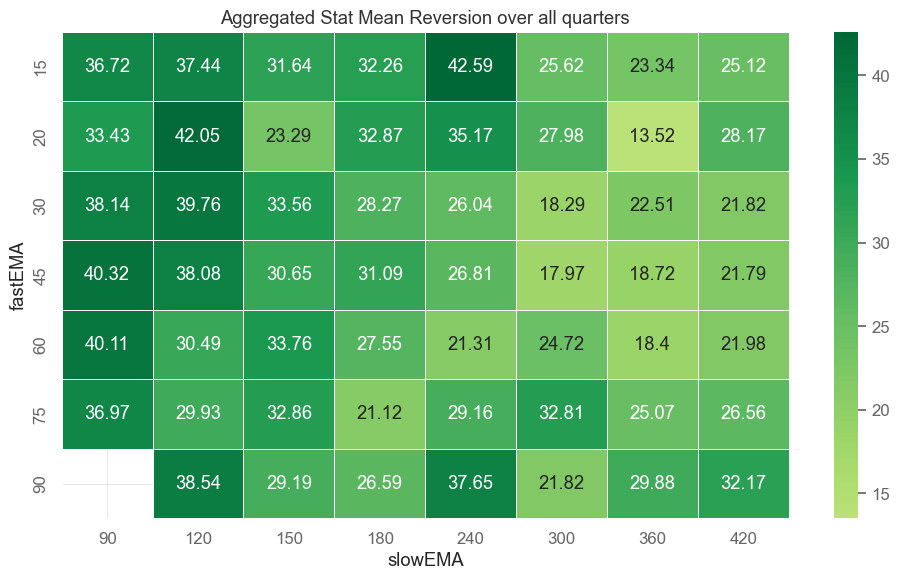

In [44]:
plot_heatmap(
    df=aggregated_stats_2MAs_stoploss,
    value_col='stat_mr_total',
    index_col='fastEMA',
    columns_col='slowEMA',
    title='Aggregated Stat Mean Reversion over all quarters')


In [56]:
def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)


signalEMA_parameters = [20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240]
volat_sd_parameters = [60, 90, 120]
m_parameters = [1, 2, 3]

# create an empty DataFrame to store summary for all quarters
summary_all_breakout_stoploss = pd.DataFrame()

for quarter in quarters:

    print(f'Processing quarter: {quarter}')

    data2 = pd.read_parquet(f'data/data2_{quarter}.parquet')

    # Lets set the datetime index
    data2.set_index('datetime', inplace=True)

    # assumption
    # let's create an object named "pos_flat"
    # = 1 if position has to be flat (= 0) - we do not trade
    # = 0 otherwise

    # let's fill it first with zeros
    pos_flat = np.zeros(len(data2))

    #
    breaks = (data2.index.time >= pd.to_datetime("16:41").time()) & \
          (data2.index.time <= pd.to_datetime("18:10").time())

    pos_flat[breaks] = 1

    dweek_ = data2.index.dayofweek + 1
    time_ = data2.index.time
    pos_flat[((dweek_ == 5) & (time_ > pd.to_datetime('17:00').time())) |      # end of Friday
          (dweek_ == 6) |                                                      # whole Saturday (just in case)
          ((dweek_ == 7) & (time_ <= pd.to_datetime('18:00').time()))] = 1     # beginning of Sunday

    # apply the strategy
    ##############################################################
    XAG = data2['XAG']

    # create a dataframe to store results
    # loop over different parameter combinations
    for signalEMA in signalEMA_parameters:
        print(f"signalEMA = {signalEMA}")
        for slowEMA in slowEMA_parameters:
            for volat_sd in volat_sd_parameters:
                for m in m_parameters:
                    # We calculate the appropriate EMA
                    signalEMA_values = XAG.ewm(span=signalEMA).mean().to_numpy()
                    slowEMA_values = XAG.ewm(span=slowEMA).mean().to_numpy()

                    # We calculate the standard deviation
                    volat_sd_values = XAG.rolling(window=volat_sd).std().to_numpy()

                    # Insert NaNs wherever the original price is missing
                    signalEMA_values[XAG.isna()] = np.nan
                    slowEMA_values[XAG.isna()] = np.nan
                    volat_sd_values[XAG.isna()] = np.nan

                    # Calculate position for momentum strategy
                    pos_mom = positionVB(signal=signalEMA_values,
                                         lower=slowEMA_values - m * volat_sd_values,
                                         upper=slowEMA_values + m * volat_sd_values,
                                         pos_flat=pos_flat,
                                         strategy="mom")

                    pos_mr = -pos_mom

                    # Calculate gross pnl
                    pnl_gross_mom = np.where(np.isnan(pos_mom * XAG.diff()), 0, pos_mom * XAG.diff() * 5000)
                    pnl_gross_mr = np.where(np.isnan(pos_mr * XAG.diff()), 0, pos_mr * XAG.diff() * 5000)
                    # point value for XAG

                     # Add stop loss condition
                    # Calculate cumulative PnL for each day and apply stop loss
                    pnl_gross_mom_series = pd.Series(pnl_gross_mom, index=data2.index)
                    pnl_gross_mr_series = pd.Series(pnl_gross_mr, index=data2.index)

                    # Define stop loss threshold (e.g., -1000 per day)
                    stop_loss_threshold = -1000

                    # Calculate cumulative daily PnL
                    daily_cumul_pnl_mom = pnl_gross_mom_series.groupby(data2.index.date).cumsum()
                    daily_cumul_pnl_mr = pnl_gross_mr_series.groupby(data2.index.date).cumsum()

                    # Create stop loss mask (stop trading for rest of day if threshold hit)
                    stop_loss_triggered_mom = (daily_cumul_pnl_mom <= stop_loss_threshold).groupby(data2.index.date).cummax()
                    stop_loss_triggered_mr = (daily_cumul_pnl_mr <= stop_loss_threshold).groupby(data2.index.date).cummax()

                    # Apply stop loss by setting position to 0 after trigger
                    pos_mom_sl = pos_mom.copy()
                    pos_mom_sl[stop_loss_triggered_mom] = 0
                    pos_mr_sl = pos_mr.copy()
                    pos_mr_sl[stop_loss_triggered_mr] = 0

                    # Recalculate PnL with stop loss
                    pnl_gross_mom = np.where(np.isnan(pos_mom_sl * data2['XAG'].diff()), 0, pos_mom_sl * data2['XAG'].diff() * 5000)
                    pnl_gross_mr = np.where(np.isnan(pos_mr_sl * data2['XAG'].diff()), 0, pos_mr_sl * data2['XAG'].diff() * 5000)
                    # Calculate number of transactions
                    ntrans = np.abs(np.diff(pos_mom, prepend=0))

                    # Calculate net pnl
                    pnl_net_mom = pnl_gross_mom - ntrans * 10  # cost $10 per transaction on XAG
                    pnl_net_mr = pnl_gross_mr - ntrans * 10  # cost $10 per transaction on XAG

                    # Aggregate to daily data
                    pnl_gross_mom = pd.Series(pnl_gross_mom)
                    pnl_gross_mom.index = XAG.index.time
                    pnl_gross_mom_d = pnl_gross_mom.groupby(XAG.index.date).sum()
                    pnl_gross_mr = pd.Series(pnl_gross_mr)
                    pnl_gross_mr.index = XAG.index.time
                    pnl_gross_mr_d = pnl_gross_mr.groupby(XAG.index.date).sum()

                    pnl_net_mom = pd.Series(pnl_net_mom)
                    pnl_net_mom.index = XAG.index.time
                    pnl_net_mom_d = pnl_net_mom.groupby(XAG.index.date).sum()
                    pnl_net_mr = pd.Series(pnl_net_mr)
                    pnl_net_mr.index = XAG.index.time
                    pnl_net_mr_d = pnl_net_mr.groupby(XAG.index.date).sum()

                    ntrans = pd.Series(ntrans)
                    ntrans.index = XAG.index.time
                    ntrans_d = ntrans.groupby(XAG.index.date).sum()

                    # Calculate Sharpe Ratio and PnL
                    gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                    net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                    gross_PnL_mom = pnl_gross_mom_d.sum()
                    net_PnL_mom = pnl_net_mom_d.sum()
                    gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                    net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                    gross_PnL_mr = pnl_gross_mr_d.sum()
                    net_PnL_mr = pnl_net_mr_d.sum()

                    av_daily_ntrans = ntrans_d.mean()

                    stat_mom = (net_SR_mom - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mom / 1000)))
                    stat_mr = (net_SR_mr - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mr / 1000)))
                    # Collect the necessary results into one object
                    summary = pd.DataFrame({
                        'signalEMA': signalEMA,
                        'slowEMA': slowEMA,
                        'volat_sd': volat_sd,
                        'm': m,
                        'quarter': quarter,
                        'gross_SR_mom': gross_SR_mom,
                        'net_SR_mom': net_SR_mom,
                        'gross_PnL_mom': gross_PnL_mom,
                        'net_PnL_mom': net_PnL_mom,
                        'gross_SR_mr': gross_SR_mr,
                        'net_SR_mr': net_SR_mr,
                        'gross_PnL_mr': gross_PnL_mr,
                        'net_PnL_mr': net_PnL_mr,
                        'av_daily_ntrans': av_daily_ntrans,
                        'stat_mom': stat_mom,
                        'stat_mr': stat_mr
                    }, index=[0])

                    # Append the results to the summary
                    summary_all_breakout_stoploss = pd.concat([summary_all_breakout_stoploss, summary], ignore_index=True)

Processing quarter: 2023_Q1
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2023_Q3
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2023_Q4
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2024_Q2
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2024_Q4
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2025_Q1
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2025_Q2
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90


In [57]:
summary_all_breakout_stoploss["signalEMA_slowEMA"] = (
    summary_all_breakout_stoploss["signalEMA"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout_stoploss["slowEMA"].astype(int).astype(str).str.zfill(3)
)

summary_all_breakout_stoploss["volat_sd_m"] = (
    summary_all_breakout_stoploss["volat_sd"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout_stoploss["m"].astype(str)
)

summary_all_breakout_stoploss.head()

signalEMA  slowEMA  volat_sd  m  quarter  gross_SR_mom  net_SR_mom  \
0         20       90        60  1  2023_Q1      1.407802    1.093790   
1         20       90        60  2  2023_Q1     -2.589374   -2.820947   
2         20       90        60  3  2023_Q1     -0.971410   -1.134348   
3         20       90        90  1  2023_Q1      0.753900    0.452516   
4         20       90        90  2  2023_Q1     -1.747731   -1.768823   

   gross_PnL_mom  net_PnL_mom  gross_SR_mr  net_SR_mr  gross_PnL_mr  \
0         9545.0       7445.0     3.929566   3.584777       22555.0   
1        -3910.0      -4330.0     2.064260   1.938485        6155.0   
2         -890.0      -1050.0    -1.408327  -1.575916       -1175.0   
3         4575.0       2755.0     5.009447   4.702749       26745.0   
4         -880.0       -900.0     1.621243   1.546918         275.0   

   net_PnL_mr  av_daily_ntrans  stat_mom    stat_mr signalEMA_slowEMA  \
0     20455.0         2.692308  1.192059   9.310559           020_090   
1      5735.0         0.538462 -4.867072   2.512440           020_090   
2     -1335.0         0.205128 -0.079740  -0.599797           020_090   
3     24925.0         2.333333 -0.048121  13.515498           020_090   
4       255.0         0.025641 -0.000000   0.000000           020_090   

  volat_sd_m  
0      060_1  
1      060_2  
2      060_3  
3      090_1  
4      090_2

In [58]:
aggregated_stats_breakout_stoploss = (
    summary_all_breakout_stoploss
    .groupby(['signalEMA_slowEMA', 'volat_sd_m'], as_index=False)
    .agg(
        stat_mom_total=('stat_mom', 'sum'),
        stat_mr_total=('stat_mr', 'sum'),
        quarters_count=('quarter', 'nunique'),
        net_SR_mom_mean=('net_SR_mom', 'mean'),
        net_SR_mr_mean=('net_SR_mr', 'mean'),
        net_PnL_mom_total=('net_PnL_mom', 'sum'),
        net_PnL_mr_total=('net_PnL_mr', 'sum'),
        av_daily_ntrans_mean=('av_daily_ntrans', 'mean')
    )
)

aggregated_stats_breakout_stoploss['stat_mom_total'] = aggregated_stats_breakout_stoploss['stat_mom_total'].round(2)
aggregated_stats_breakout_stoploss['stat_mr_total'] = aggregated_stats_breakout_stoploss['stat_mr_total'].round(2)

In [59]:
aggregated_stats_breakout_stoploss

signalEMA_slowEMA volat_sd_m  stat_mom_total  stat_mr_total  \
0             020_090      060_1           34.73          33.65   
1             020_090      060_2          -11.55          -5.38   
2             020_090      060_3            0.99          -2.77   
3             020_090      090_1           14.38          36.47   
4             020_090      090_2            0.93           0.00   
..                ...        ...             ...            ...   
265           090_240      090_2           14.50           2.42   
266           090_240      090_3            4.50          -2.95   
267           090_240      120_1            8.12           8.56   
268           090_240      120_2            8.31           3.62   
269           090_240      120_3            1.50          -0.93   

     quarters_count  net_SR_mom_mean  net_SR_mr_mean  net_PnL_mom_total  \
0                 7         2.217968        2.142740           117895.0   
1                 7        -0.710372        0.205540             2125.0   
2                 7        -0.816341       -0.431445             -555.0   
3                 7         1.372510        2.289555            62845.0   
4                 7        -1.345730       -0.465383             1645.0   
..              ...              ...             ...                ...   
265               7         1.232207        0.411808            40960.0   
266               7         0.840046       -0.634088            12570.0   
267               7         0.800404        0.796103            38095.0   
268               7         0.863928        0.703567            28635.0   
269               7         0.422312       -0.502444             5935.0   

     net_PnL_mr_total  av_daily_ntrans_mean  
0             98860.0              2.484924  
1              7625.0              0.552994  
2             -2420.0              0.171976  
3             90940.0              2.069457  
4               -75.0              0.025641  
..                ...                   ...  
265           13625.0              0.585639  
266           -3330.0              0.237916  
267           26975.0              0.908374  
268            8900.0              0.241624  
269           -2560.0              0.058469  

[270 rows x 10 columns]

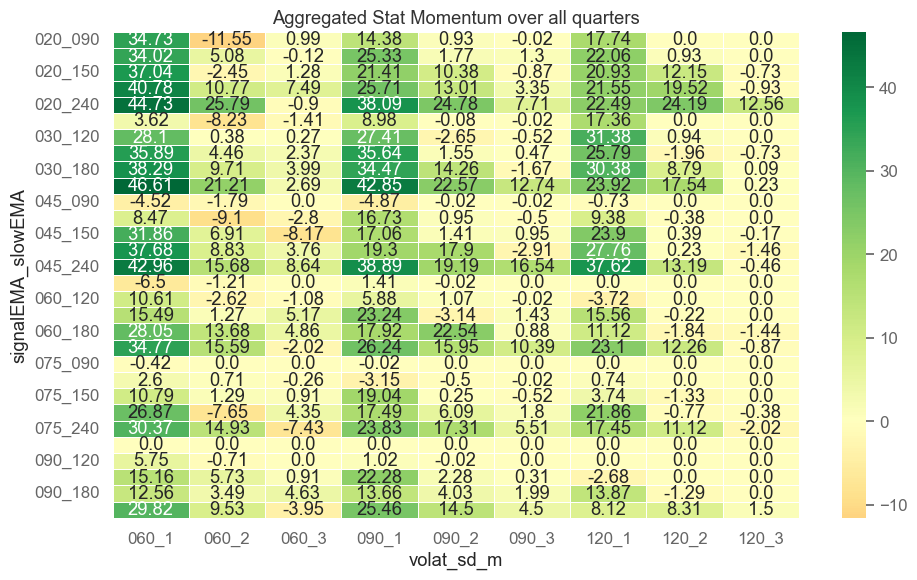

In [60]:

plot_heatmap(
    df=aggregated_stats_breakout_stoploss,
    value_col='stat_mom_total',
    index_col='signalEMA_slowEMA',
    columns_col='volat_sd_m',
    title='Aggregated Stat Momentum over all quarters')

#a lot better

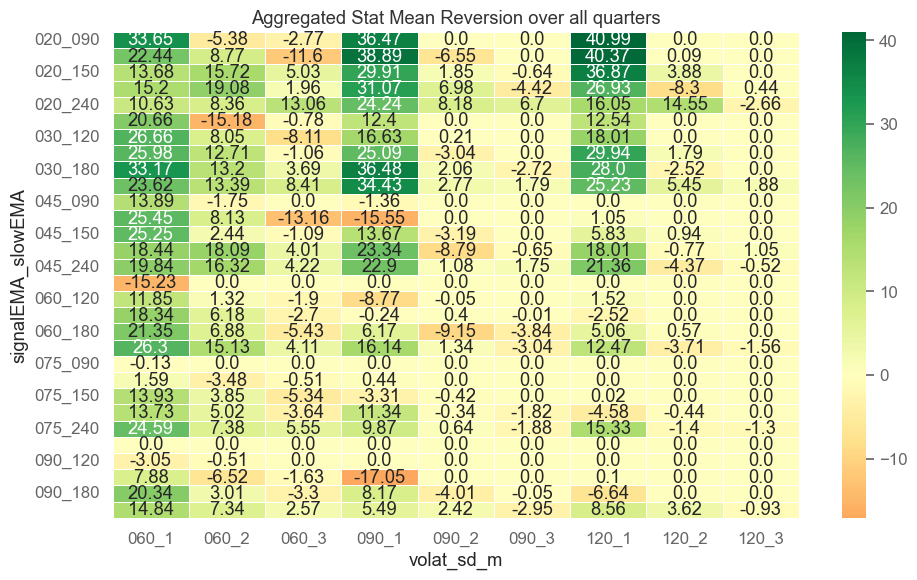

In [61]:
plot_heatmap(
    df=aggregated_stats_breakout_stoploss,
    value_col='stat_mr_total',
    index_col='signalEMA_slowEMA',
    columns_col='volat_sd_m',
    title='Aggregated Stat Mean Reversion over all quarters'
)